## SDEexpJump, SDEgauJump, SDEnoJump, OU is compared on the synthetic dataset

In [1]:
import sys,os
import numpy as np
import scipy.stats as stats
from scipy import linalg
from numpy import dot
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import grad
import torch.utils.data
import torch.backends.cudnn as cudnn
from torch.nn.modules import Linear
from torch.autograd.functional import jacobian,hessian,vjp,vhp,hvp

import random
import math

def setup_seed(seed):
     torch.cuda.manual_seed(seed)
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.benchmark=False
     torch.backends.cudnn.deterministic = True

def PopulationSample(path,time,samples_n,samples_total,in_features): 
    indices = list(range(samples_total)) 
    random.shuffle(indices) 
    train = torch.empty((samples_n,in_features),device="cuda")
    j = 0
    for i in indices[:samples_n]:
        train[j] = path[i][time]
        j += 1

    test = torch.empty((samples_total-samples_n,in_features),device="cuda")
    j = 0
    for i in indices[samples_n:]:
        test[j] = path[i][time]
        j += 1

    return train,test

class Synthetic2D(nn.Module):

    def __init__(self,in_features,diffusion,intensity,mean,cov,step_size,mu1,mu2,S,index):
        super(Synthetic2D,self).__init__()

        self.diffusion = diffusion
        self.intensity = intensity

        self.mean = mean
        self.cov = cov
        self.in_features = in_features
        self.step_size = step_size
        self.index = index
        self.mu1 = mu1
        self.mu2 = mu2
        self.S = S

    def drift(self,x):
        if self.index == 1:
            xp = torch.tensor([x[0],x[0]],device="cuda")
            p = 1/(1+self.S[0]/self.S[1]*torch.exp((x[0]-self.mu1[0])**2/(2*self.S[0]**2)+(x[0]-self.mu1[1])**2/(2*self.S[0]**2)-(x[1]-self.mu2[0])**2/(2*self.S[1]**2)-(x[1]-self.mu2[1])**2/(2*self.S[1]**2)))
            return -(1/self.S[0]*p*(x-self.mu1)+1/self.S[1]*(1-p)*(xp-self.mu2))

    def forward(self,z0,steps):
        
        path = torch.empty(size = (steps+1,self.in_features),device="cuda")
        path[0] = z0
        state = z0
        ta = 0
        tb = 0
        tb += torch.distributions.Exponential(self.intensity).sample()
        i = 1
        while i<= steps:

            if tb <  i*self.step_size:
                state = state + self.drift(state)*(tb-ta) + math.sqrt(tb-ta)*self.diffusion*torch.normal(0,1,size=(self.in_features,),device="cuda")+\
                        torch.distributions.Exponential(torch.tensor([10.0,1.0])).sample().cuda()
                ta = tb
                tb = tb + torch.distributions.Exponential(self.intensity).sample()

            elif tb > i*self.step_size:
                state = state + self.drift(state)*(i*self.step_size-ta) + math.sqrt(i*self.step_size-ta)*self.diffusion*torch.normal(0,1,size=(self.in_features,),device="cuda")
                path[i] = state
                ta = i*self.step_size
                i += 1
            else:
                state = state + self.drift(state)*(tb-ta) + math.sqrt(tb-ta)*self.diffusion*torch.normal(0,1,size=(self.in_features,),device="cuda")+\
                        torch.distributions.Exponential(torch.tensor([10.0,1.0])).sample()
                path[i]  = state
                ta = i*self.step_size
                tb = tb + torch.distributions.Exponential(self.intensity).sample().cuda()
                i += 1

        return path

setup_seed(80)
## data generation
Synthetic = Synthetic2D(2,1,40,torch.tensor([0.01,0.05],device="cuda"),0.08*torch.eye(2,device="cuda"),0.02,torch.tensor([16,12],device="cuda"),\
                       torch.tensor([-18,-10],device="cuda"),torch.tensor([1,0.95],device="cuda"),1).cuda()

init_state = D.MultivariateNormal(torch.zeros(2,device="cuda"),torch.eye(2,device="cuda")).sample((2000,))

PopulationPath = list(map(Synthetic,init_state,[10]*2000))

train0,test0 = PopulationSample(PopulationPath,0,1200,2000,2)
train2,test2 = PopulationSample(PopulationPath,2,1200,2000,2)
train3,test3 = PopulationSample(PopulationPath,3,1200,2000,2)
train4,test4 = PopulationSample(PopulationPath,4,1200,2000,2)
train6,test6 = PopulationSample(PopulationPath,6,1200,2000,2)
train10,test10 = PopulationSample(PopulationPath,10,1200,2000,2)


n_sims = 1200
n_steps = [3,6]
in_features = 2
step_size = 0.02

In [2]:
class MLP(nn.Module):

    def __init__(self, dim_in, dim_out, dim_hidden=64, num_hidden=0, activation=nn.Tanh(),addLast=False):
        super(MLP, self).__init__()

        if num_hidden == 0:
            self.linears = nn.ModuleList([nn.Linear(dim_in, dim_out)])
        elif num_hidden >= 1:
            self.linears = nn.ModuleList() 
            self.linears.append(nn.Linear(dim_in, dim_hidden))
            self.linears.extend([nn.Linear(dim_hidden, dim_hidden) for _ in range(num_hidden-1)])
            self.linears.append(nn.Linear(dim_hidden, dim_out))
        else:
            raise Exception('number of hidden layers must be positive')

        for m in self.linears:
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias,0) 
 
        self.activation = activation
        self.addLast = addLast

    def forward(self, x):
        for m in self.linears[:-1]:
            x = self.activation(m(x))

        if self.addLast:
            return nn.Softplus()(self.linears[-1](x))

        return self.linears[-1](x)

## OU

In [3]:
class JumpEulerForwardCuda(nn.Module):
    def __init__(self,in_features,step_size):
        super(JumpEulerForwardCuda,self).__init__()
        
        self.mu = nn.Parameter(torch.ones(1,in_features))
        self.theta = nn.Parameter(torch.ones(1,in_features))
        
        self.diffusion = nn.Parameter(torch.tensor(1.0))
        self.in_features = in_features
        self.step_size = step_size
        
    def drift(self,x):
        return self.theta*(self.mu-x)

    def forward(self,z0,Nsim,steps):

        PopulationPath = torch.empty(size = (Nsim,steps+1,self.in_features),device="cuda")
        PopulationPath[:,0,:] = z0
        state = z0

        for i in range(1,steps+1):
            state = state + self.drift(state)*self.step_size + self.diffusion*math.sqrt(self.step_size)*torch.normal(0,1,size=(Nsim,in_features),device="cuda")
            PopulationPath[:,i,:] = state
        return PopulationPath

netGou = JumpEulerForwardCuda(2,0.02).cuda()

# SDEnoJump

In [4]:
class JumpEulerForwardCuda(nn.Module):

    def __init__(self,in_features,num_hidden,dim_hidden,step_size):
        super(JumpEulerForwardCuda,self).__init__()

        self.drift = MLP(in_features,in_features,dim_hidden,num_hidden,addLast=False)
        self.diffusion = nn.Parameter(torch.tensor(1.0))
        self.in_features = in_features
        self.step_size = step_size

    def forward(self,z0,Nsim,steps):

        PopulationPath = torch.empty(size = (Nsim,steps+1,self.in_features),device="cuda")
        PopulationPath[:,0,:] = z0
        state = z0

        for i in range(1,steps+1):
            state = state + self.drift(state)*self.step_size + self.diffusion*math.sqrt(self.step_size)*torch.normal(0,1,size=(Nsim,self.in_features),device="cuda")
            PopulationPath[:,i,:] = state
        return PopulationPath

netGnj = JumpEulerForwardCuda(2,2,32,0.02).cuda()

# SDEgauJump

In [5]:
class JumpEulerForwardCuda(nn.Module):

    def __init__(self,in_features,num_hidden,dim_hidden,step_size):
        super(JumpEulerForwardCuda,self).__init__()

        self.drift = MLP(in_features,in_features,dim_hidden,num_hidden)
        self.intensity = torch.tensor(40.0,device="cuda")
        self.mean = nn.Parameter(torch.tensor([0.01,0.05]))
        self.covHalf = nn.Parameter(0.08*torch.ones(in_features))
        self.diffusion = nn.Parameter(torch.tensor(1.0))
        self.in_features = in_features
        self.step_size = step_size

    def forward(self,z0,Nsim,steps):

        PopulationPath = torch.empty(size = (Nsim,steps+1,self.in_features),device="cuda")
        PopulationPath[:,0,:] = z0
        state = z0

        for i in range(1,steps+1):
            DP = D.poisson.Poisson(self.intensity*self.step_size)
            pois = DP.sample((Nsim,1)).cuda()
            state = state + self.drift(state)*self.step_size + self.diffusion*math.sqrt(self.step_size)*torch.normal(0,1,size=(Nsim,self.in_features),device="cuda")+\
                pois*self.mean + pois**(0.5)*torch.normal(0,1,size=(Nsim,self.in_features),device="cuda")*self.covHalf
            PopulationPath[:,i,:] = state
        return PopulationPath

netGwgj = JumpEulerForwardCuda(2,2,32,0.02).cuda()

# SDEexpJump

In [6]:
class JumpEulerForwardCuda(nn.Module):

    def __init__(self,in_features,num_hidden,dim_hidden,step_size):
        super(JumpEulerForwardCuda,self).__init__()

        self.drift = MLP(in_features,in_features,dim_hidden,num_hidden,addLast=False)
        self.intensity = torch.tensor(40.0,device="cuda")
        self.rate = torch.tensor([10.0,1.0],device="cuda")
        self.diffusion = nn.Parameter(torch.tensor(1.0))
        self.in_features = in_features
        self.step_size = step_size

    def forward(self,z0,Nsim,steps):

        PopulationPath = torch.empty(size = (Nsim,steps+1,self.in_features),device="cuda")
        PopulationPath[:,0,:] = z0
        state = z0

        for i in range(1,steps+1):
            DP = D.poisson.Poisson(self.intensity*self.step_size) 
            pois = DP.sample((Nsim,1)).cuda()
            state = state + self.drift(state)*self.step_size + self.diffusion*math.sqrt(self.step_size)*torch.normal(0,1,size=(Nsim,self.in_features),device="cuda")+\
                torch.distributions.Gamma(pois,self.rate).sample().cuda()
            PopulationPath[:,i,:] = state
        return PopulationPath

netGwj = JumpEulerForwardCuda(2,2,32,0.02).cuda()

# Training error

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


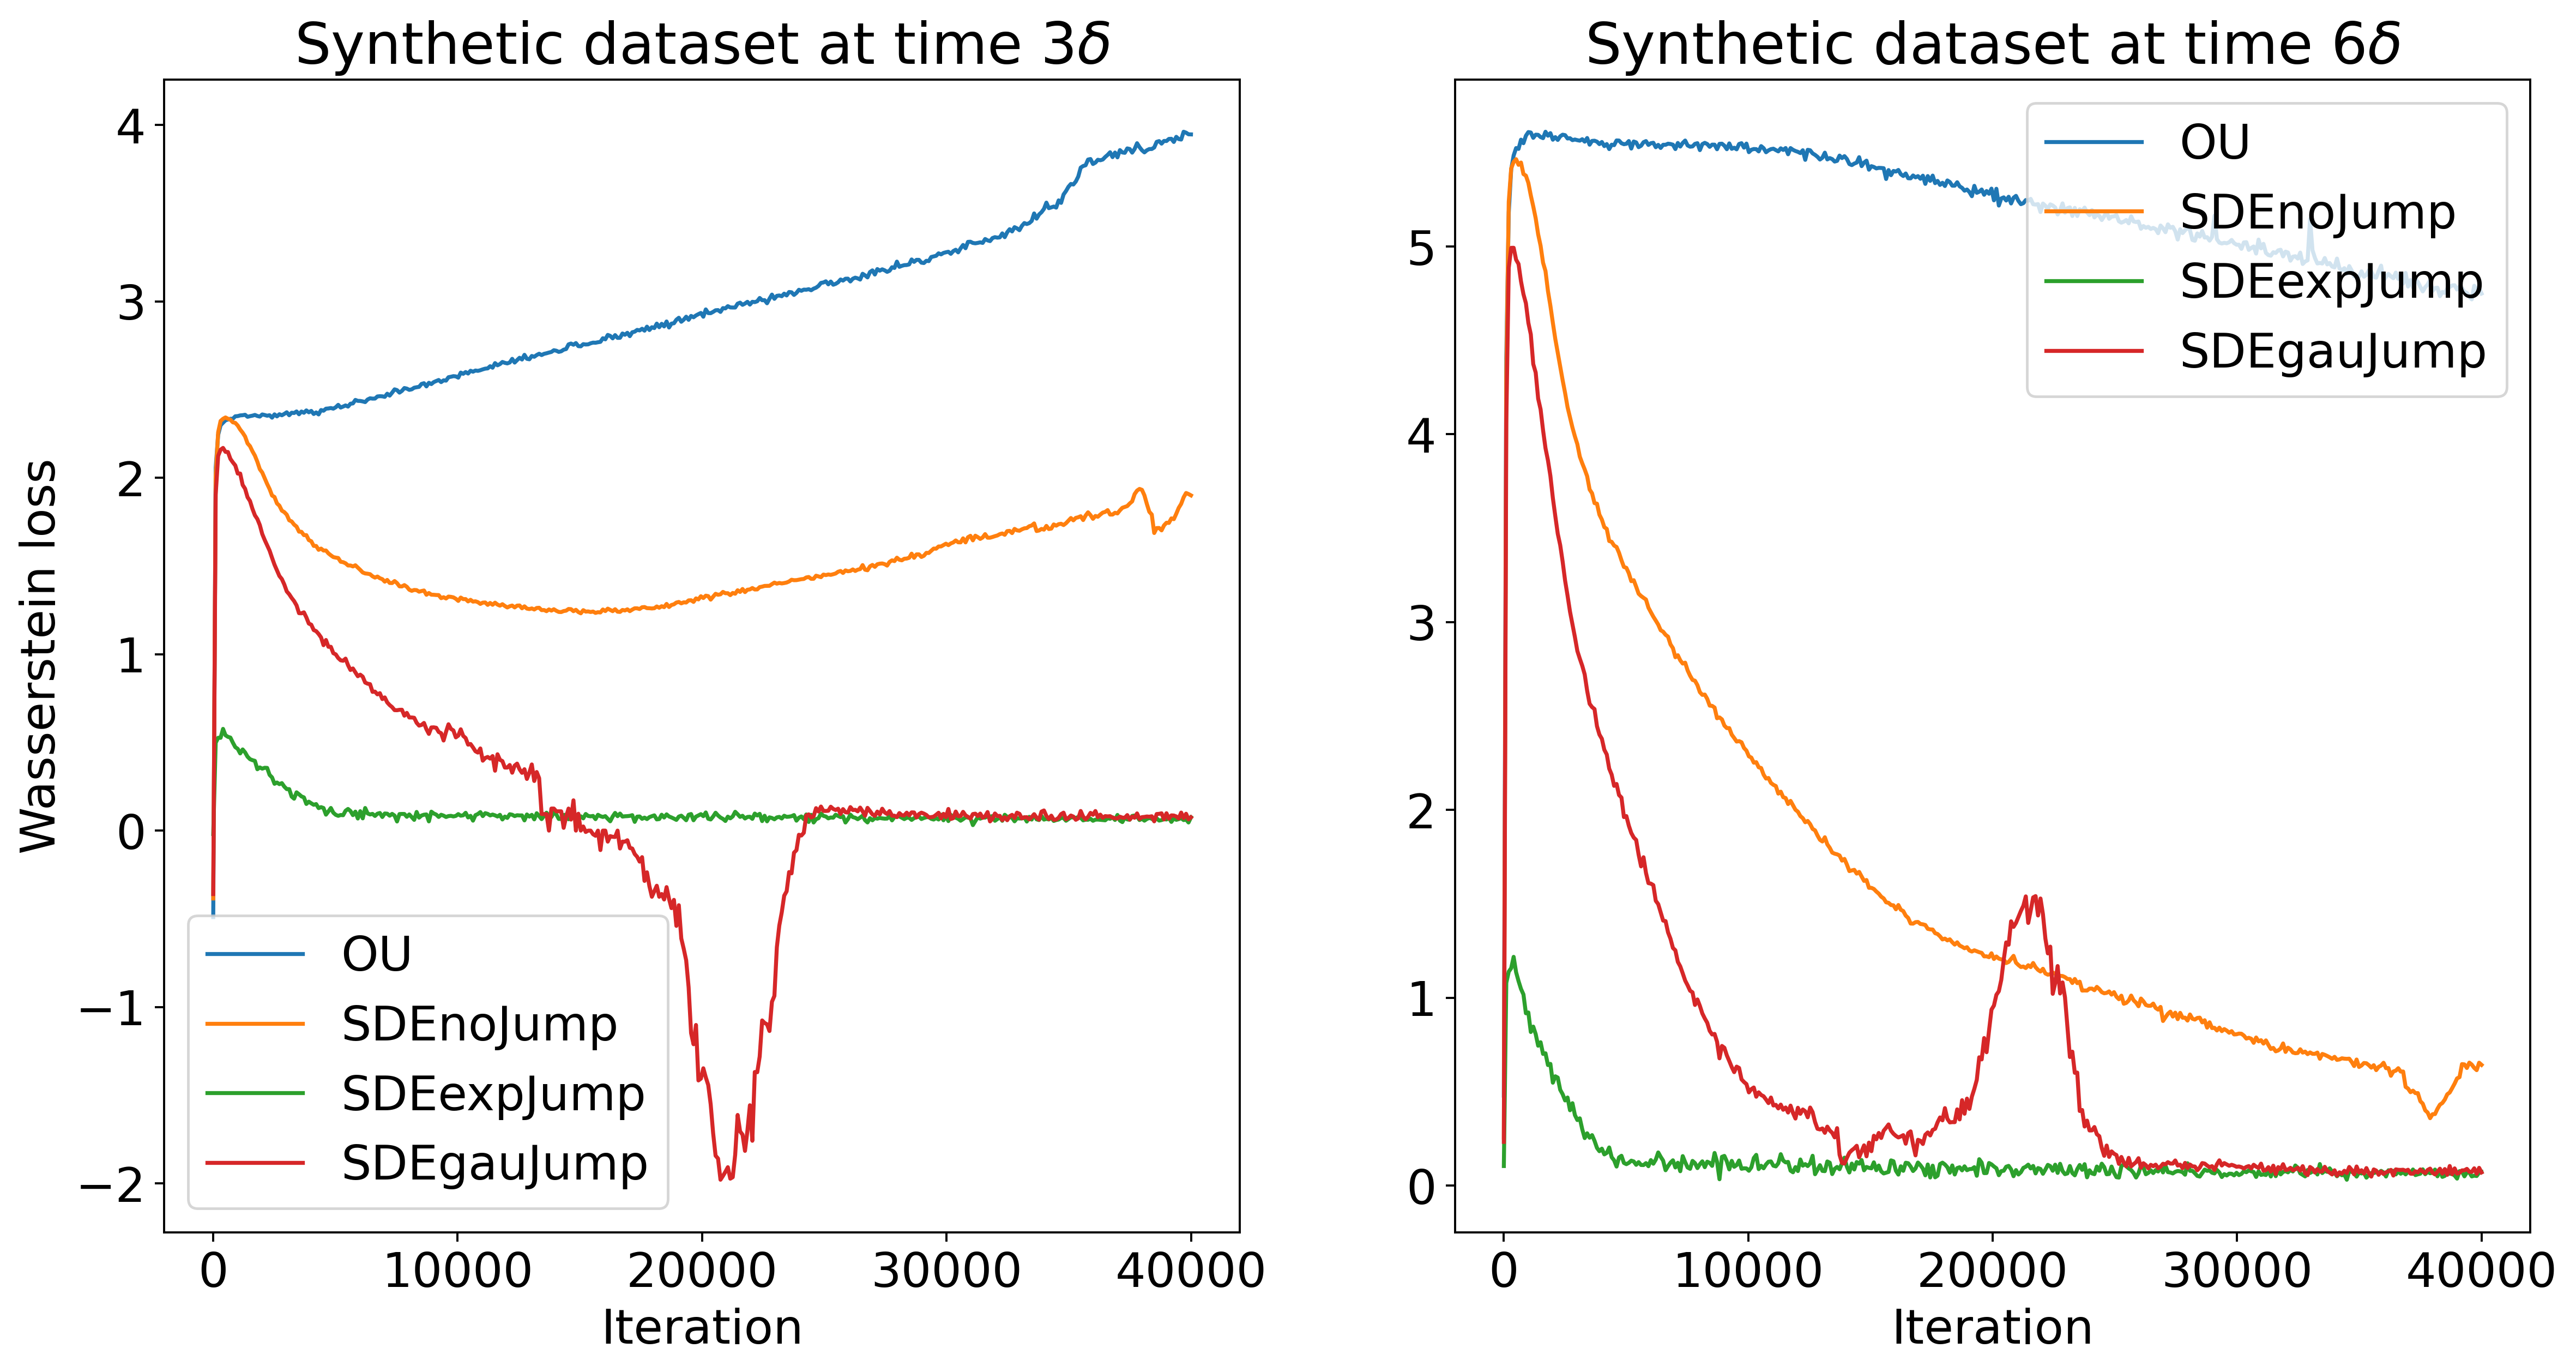

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
#matplotlib.use('Agg')
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

def clean(string):
    return float(string.strip())

with open("./WassersteinLoss/Snj1", "r") as f:
    njerr1 = f.readlines()
njerr1 = list(map(clean,njerr1))

with open("./WassersteinLoss/Snj2", "r") as f:
    njerr2 = f.readlines()
njerr2 = list(map(clean,njerr2))

with open("./WassersteinLoss/Swj1", "r") as f:
    wjerr1 = f.readlines()
wjerr1 = list(map(clean,wjerr1))

with open("./WassersteinLoss/Swj2", "r") as f:
    wjerr2 = f.readlines()
wjerr2 = list(map(clean,wjerr2))

with open("./WassersteinLoss/Swgj1", "r") as f:
    wgjerr1 = f.readlines()
wgjerr1 = list(map(clean,wgjerr1))

with open("./WassersteinLoss/Swgj2", "r") as f:
    wgjerr2 = f.readlines()
wgjerr2 = list(map(clean,wgjerr2))

with open("./WassersteinLoss/Sou1", "r") as f:
    ou1 = f.readlines()
ouerr1 = list(map(clean,ou1))

with open("./WassersteinLoss/Sou2", "r") as f:
    ou2 = f.readlines()
ouerr2 = list(map(clean,ou2))


plt.figure(figsize=(16,8),dpi=350)
plt.subplot(1,2,1)
plt.xlabel('Iteration')
plt.ylabel('Wasserstein loss')
plt.title('Synthetic dataset at time $3\delta$')
plt.plot(np.linspace(0,len(ouerr1),num=len(ouerr1[0:399999:100])),ouerr1[0:399999:100],label='OU')
plt.plot(np.linspace(0,len(njerr1),num=len(njerr1[0:399999:100])),njerr1[0:399999:100],label="SDEnoJump")
plt.plot(np.linspace(0,len(wjerr1),num=len(wjerr1[0:399999:100])),wjerr1[0:399999:100],label='SDEexpJump')
plt.plot(np.linspace(0,len(wgjerr1),num=len(wgjerr1[0:399999:100])),wgjerr1[0:399999:100],label='SDEgauJump')

plt.legend(loc=0,ncol=1)

plt.subplot(1,2,2)
plt.title('Synthetic dataset at time $6\delta$')
plt.plot(np.linspace(0,len(ouerr2),num=len(ouerr2[0:399999:100])),ouerr2[0:399999:100],label='OU')
plt.plot(np.linspace(0,len(njerr2),num=len(njerr2[0:399999:100])),njerr2[0:399999:100],label="SDEnoJump")
plt.plot(np.linspace(0,len(wjerr2),num=len(wjerr2[0:399999:100])),wjerr2[0:399999:100],label='SDEexpJump')
plt.plot(np.linspace(0,len(wgjerr2),num=len(wgjerr2[0:399999:100])),wgjerr2[0:399999:100],label='SDEgauJump')
plt.xlabel('Iteration')
plt.legend(loc=1,ncol=1)
plt.savefig('./images/strain.eps',format='eps')

# Prediction

In [8]:
netGnj.load_state_dict(torch.load('./TrainedModel/netGSnj.pt'))
netGwj.load_state_dict(torch.load('./TrainedModel/netGSwj.pt'))
netGwgj.load_state_dict(torch.load('./TrainedModel/netGSwgj.pt'))
netGou.load_state_dict(torch.load('./TrainedModel/netGSou.pt'))

<All keys matched successfully>

In [9]:
import geomloss as gs

a=gs.SamplesLoss(loss='sinkhorn',p=2,blur=0.01)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


tensor(2.0314, device='cuda:0', grad_fn=<SelectBackward>) tensor(6.4115, device='cuda:0', grad_fn=<SelectBackward>) tensor(35.5709, device='cuda:0', grad_fn=<SelectBackward>)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


tensor(0.1862, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.2396, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.2901, device='cuda:0', grad_fn=<SelectBackward>)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


tensor(0.0237, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.0439, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.1025, device='cuda:0', grad_fn=<SelectBackward>)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


tensor(0.0320, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.0104, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.0781, device='cuda:0', grad_fn=<SelectBackward>)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


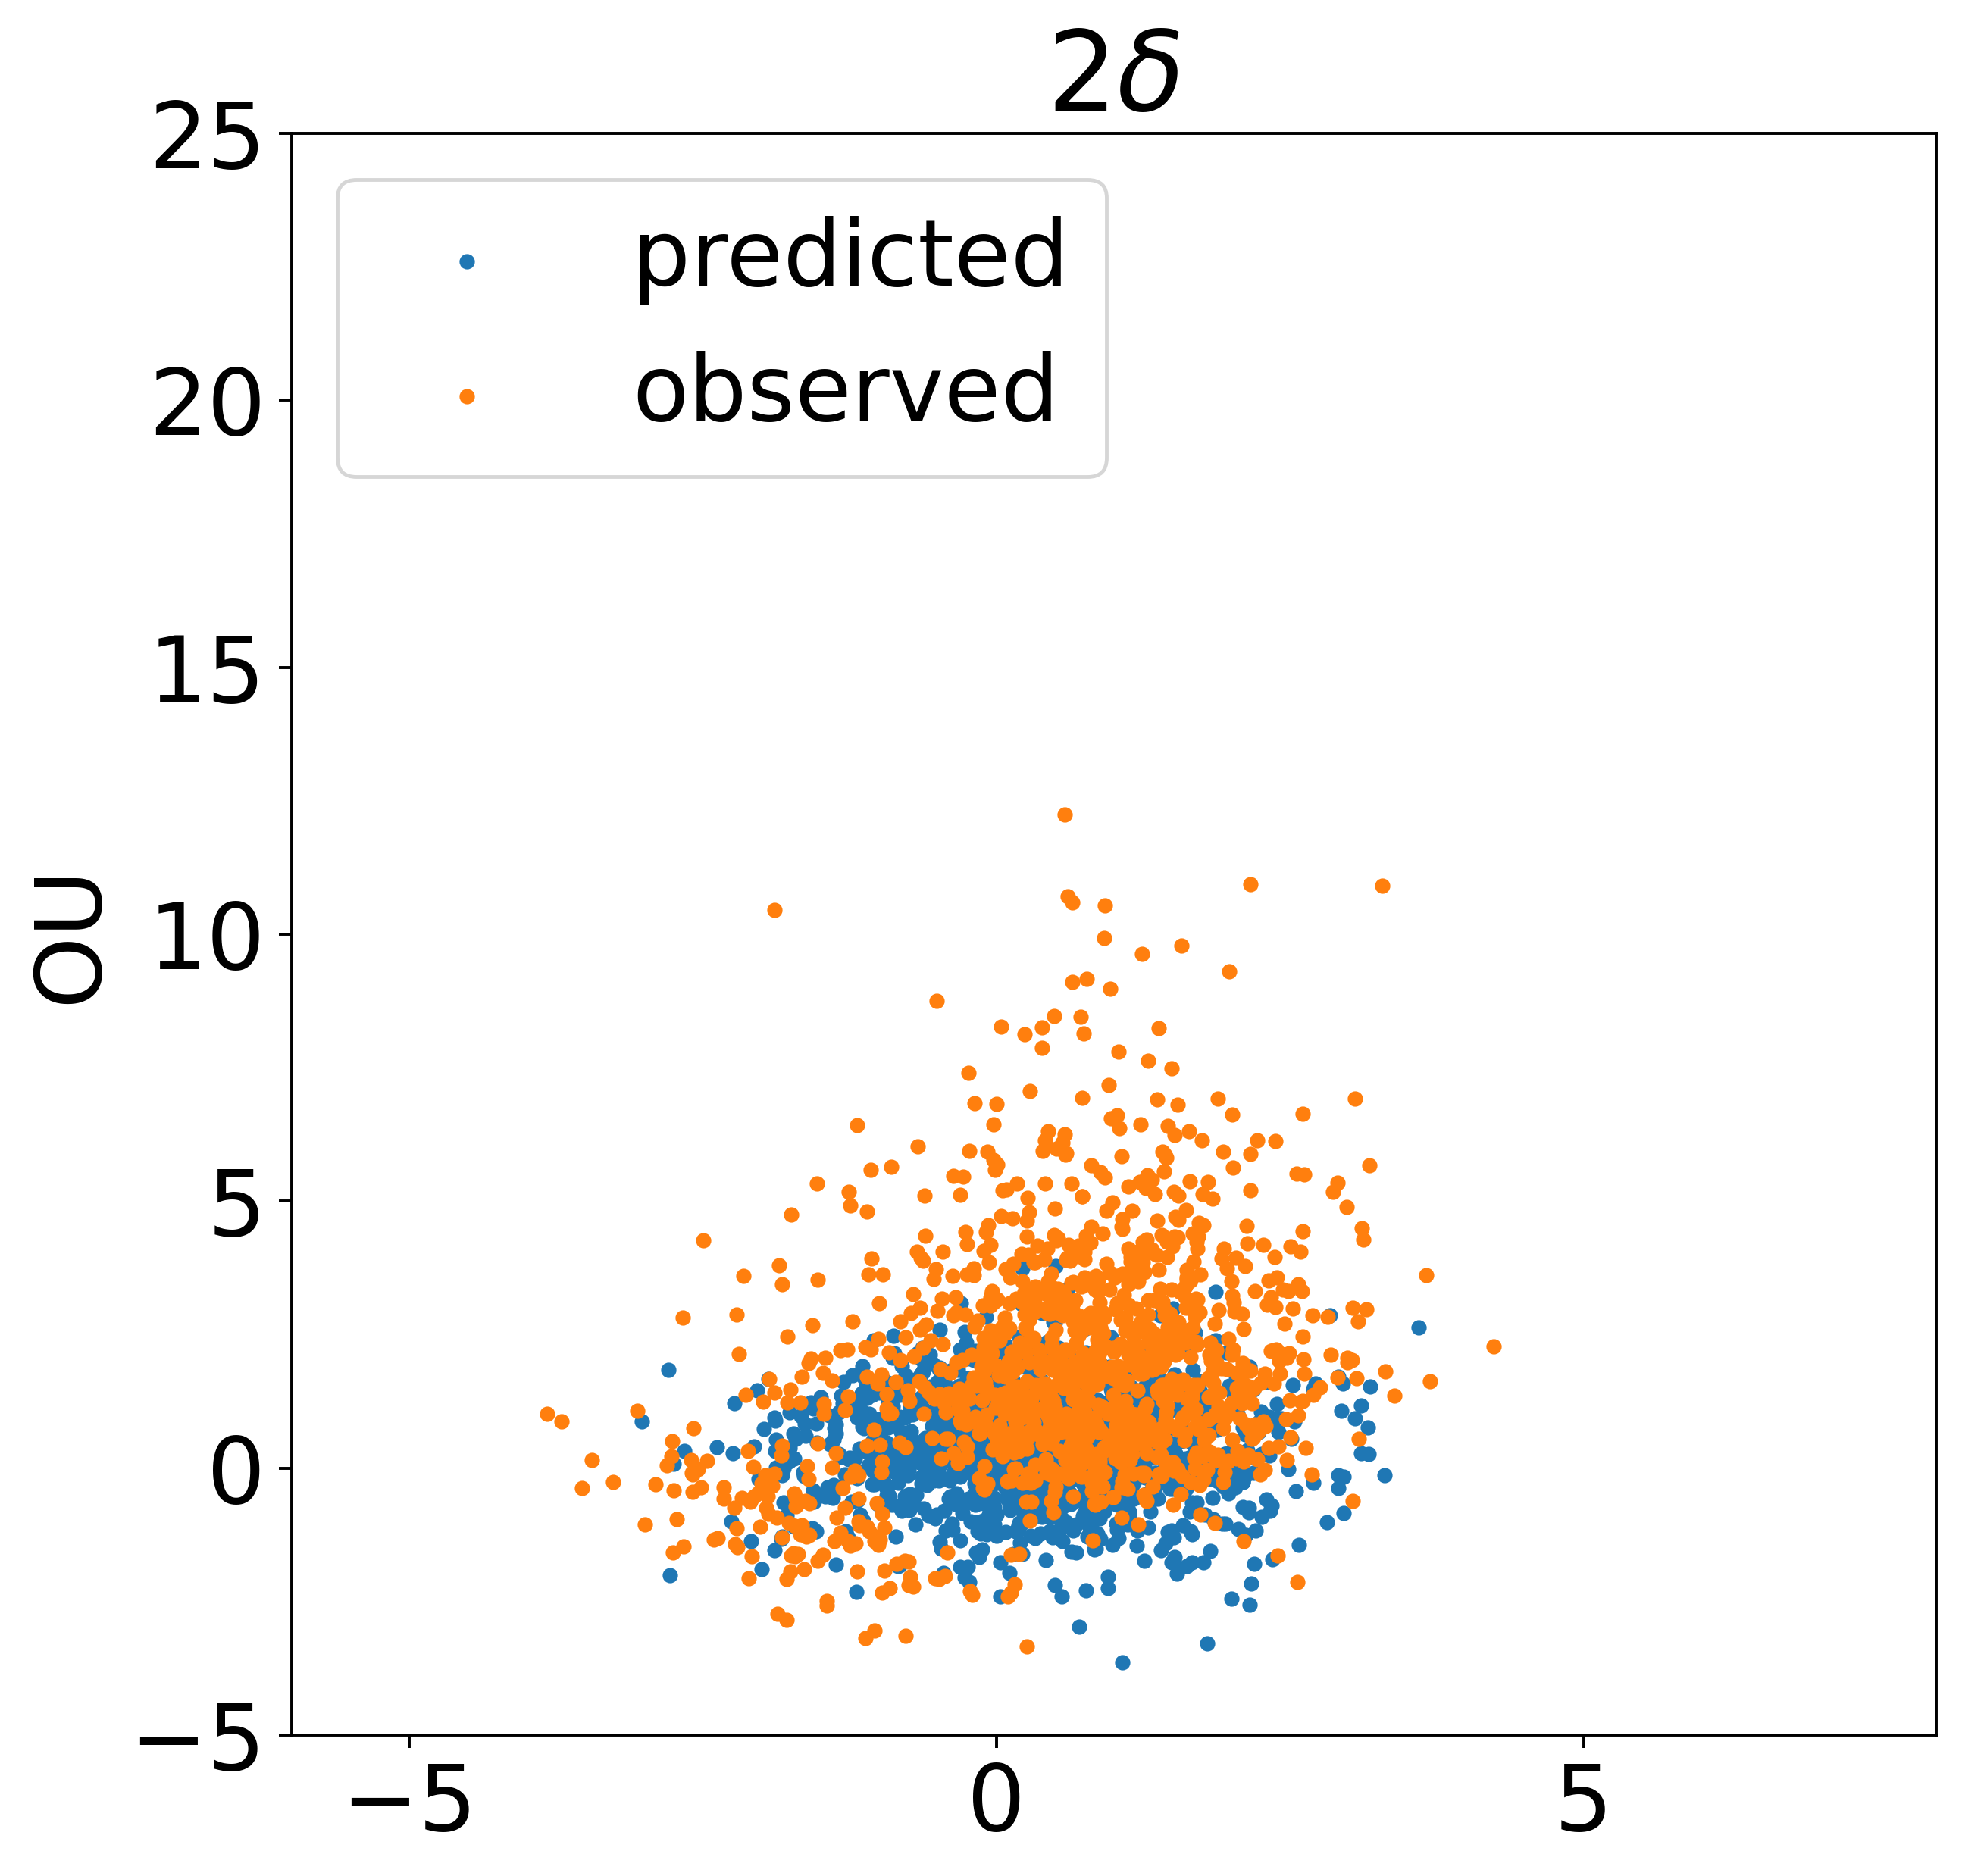

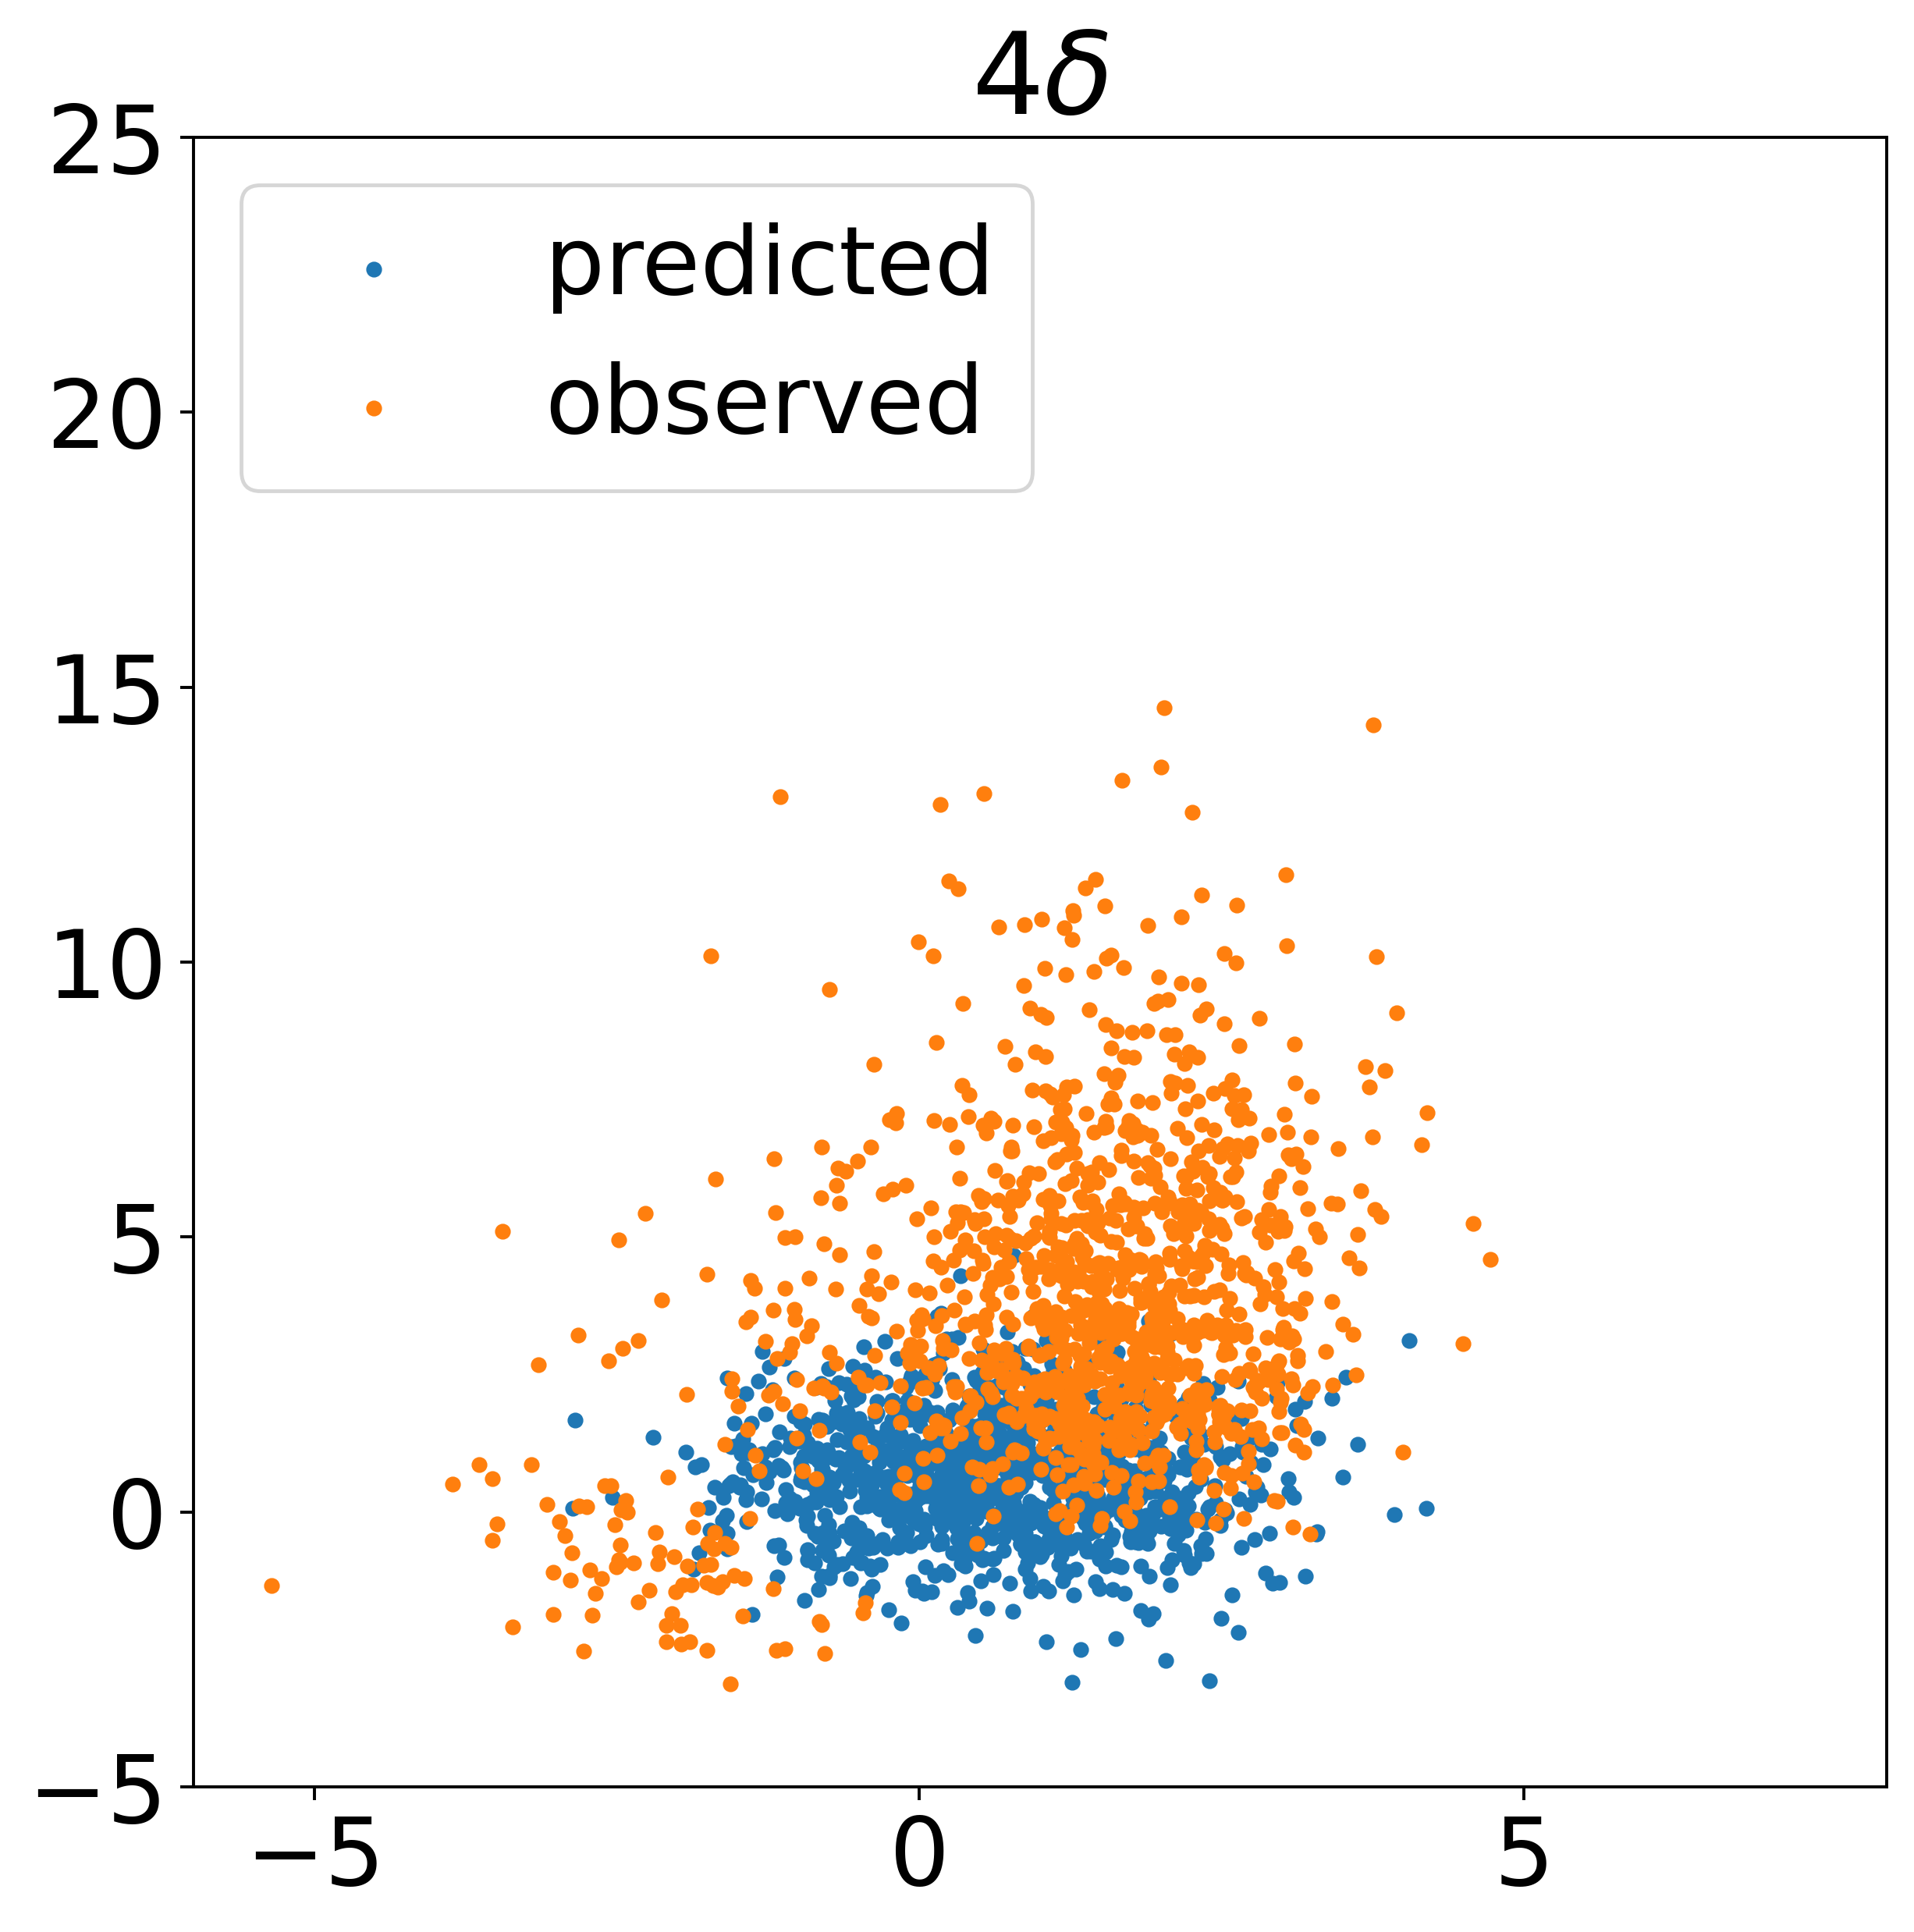

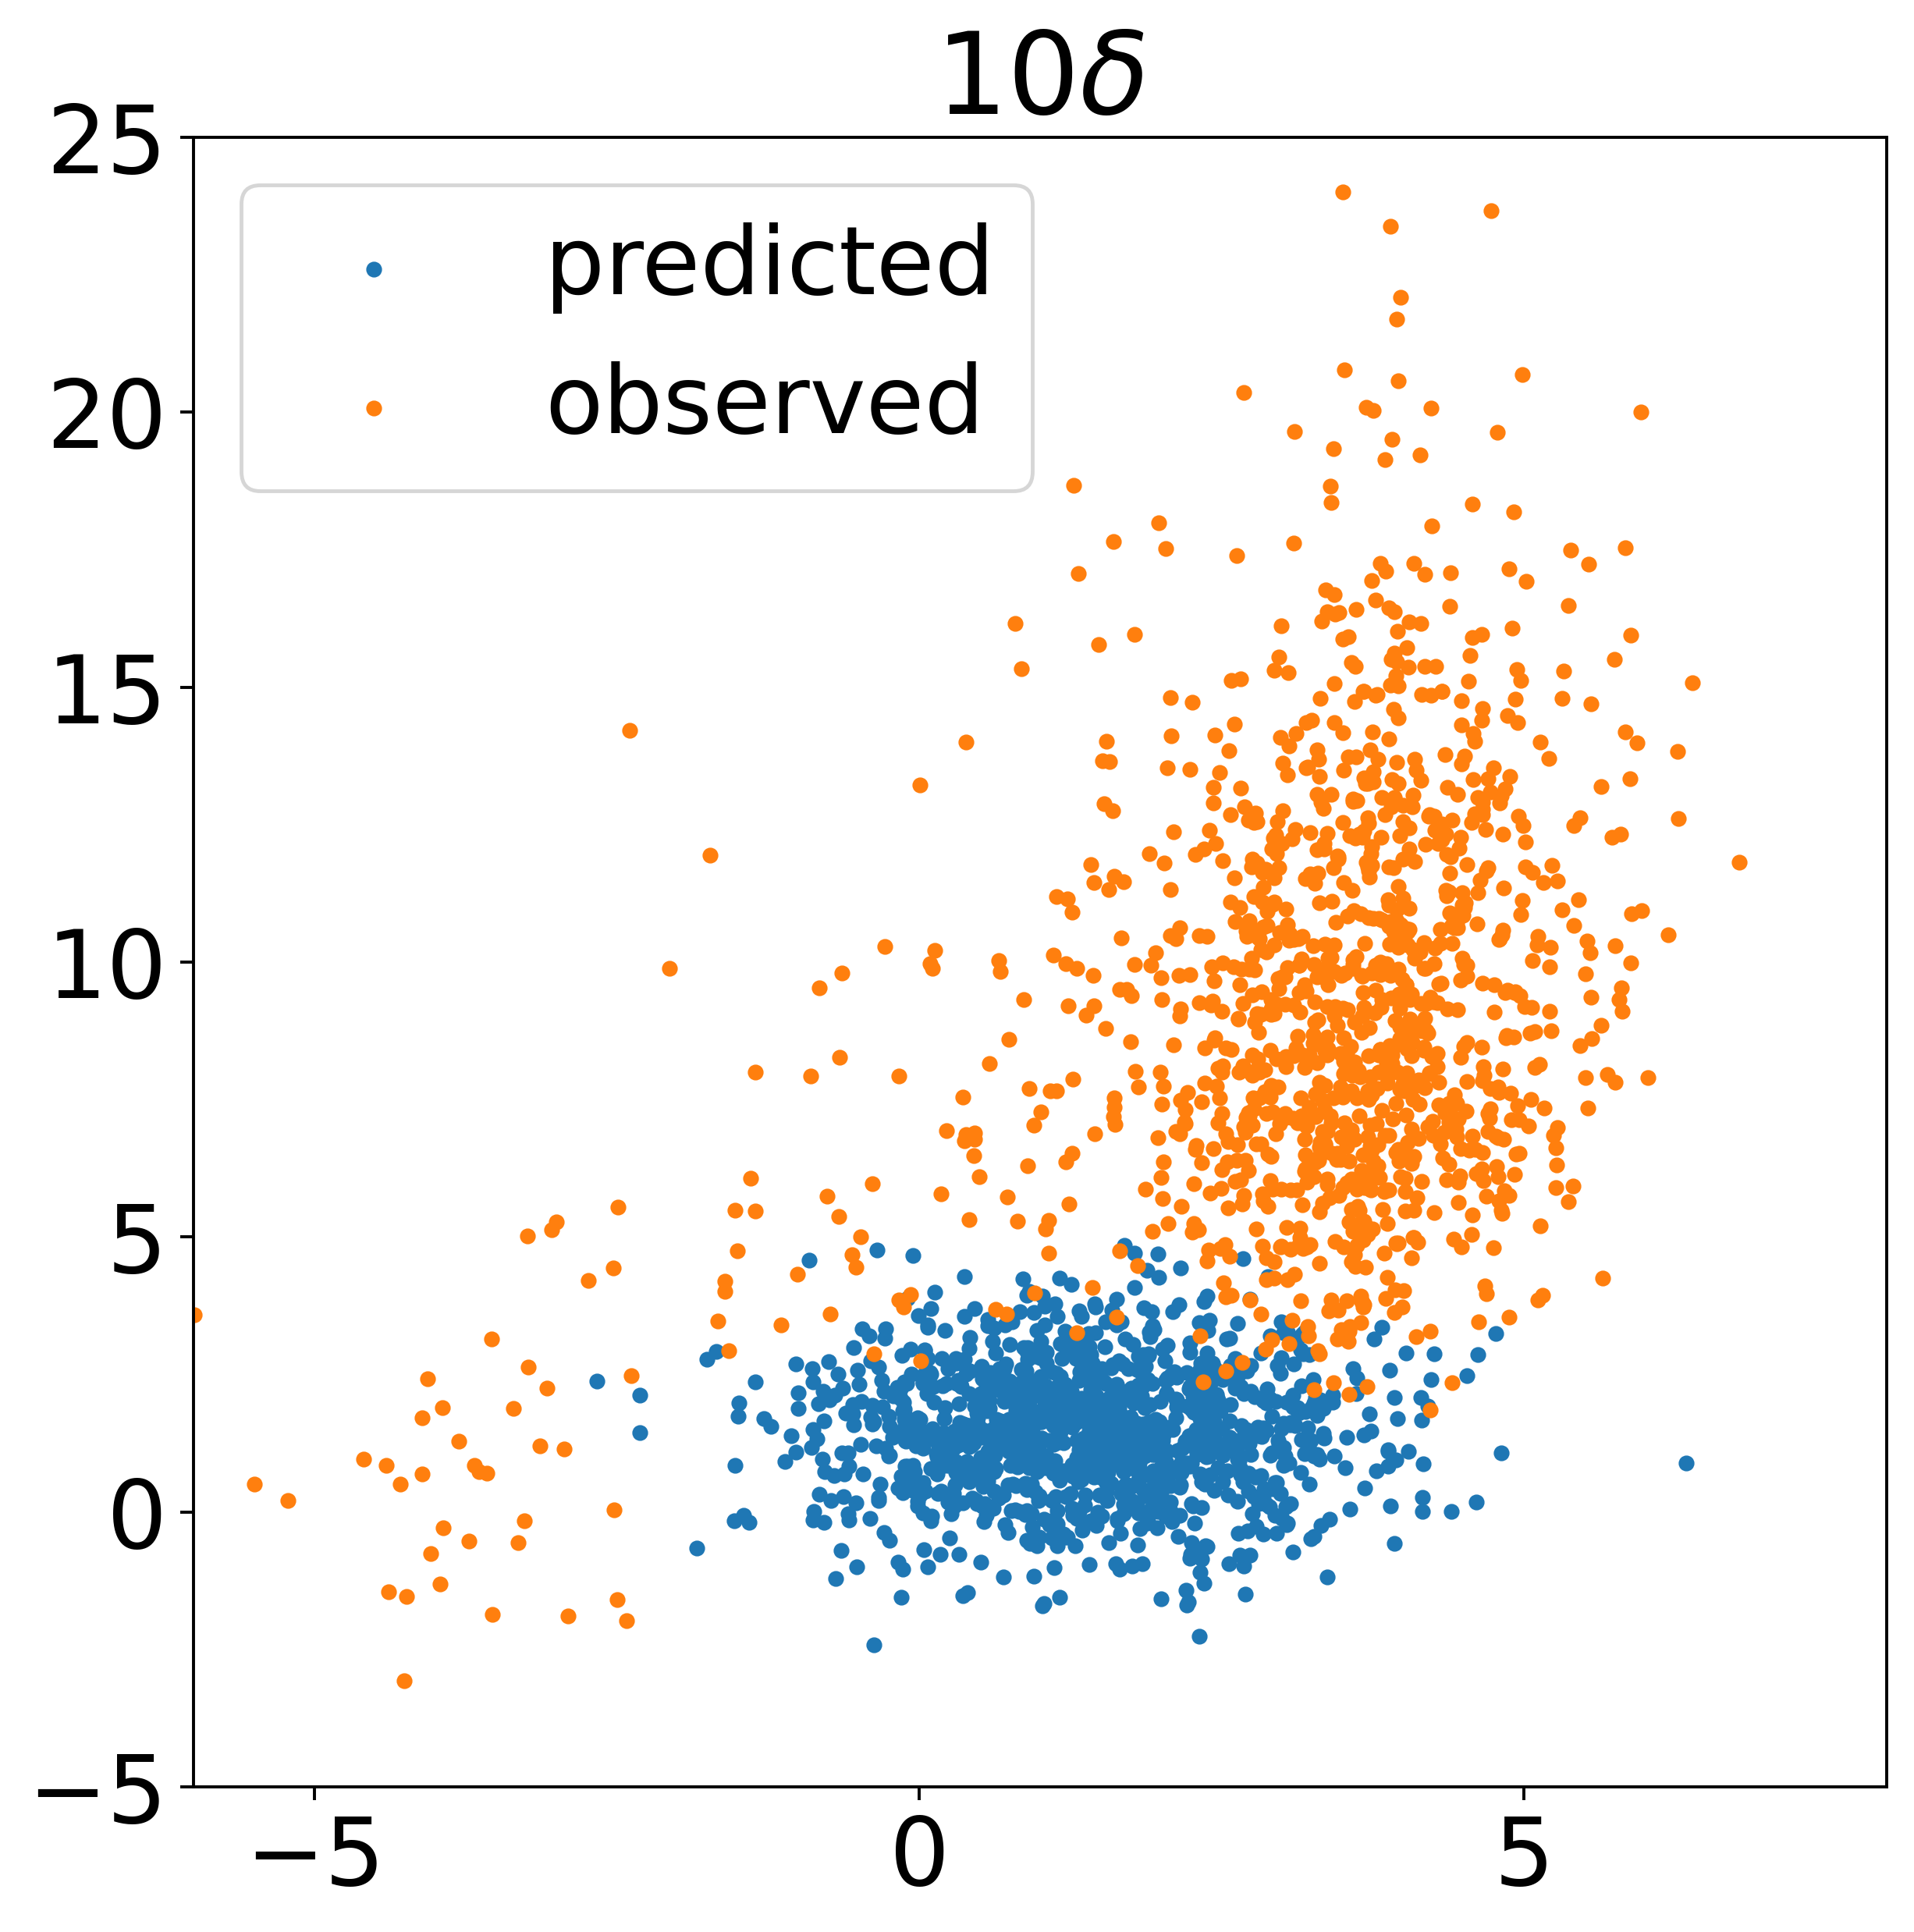

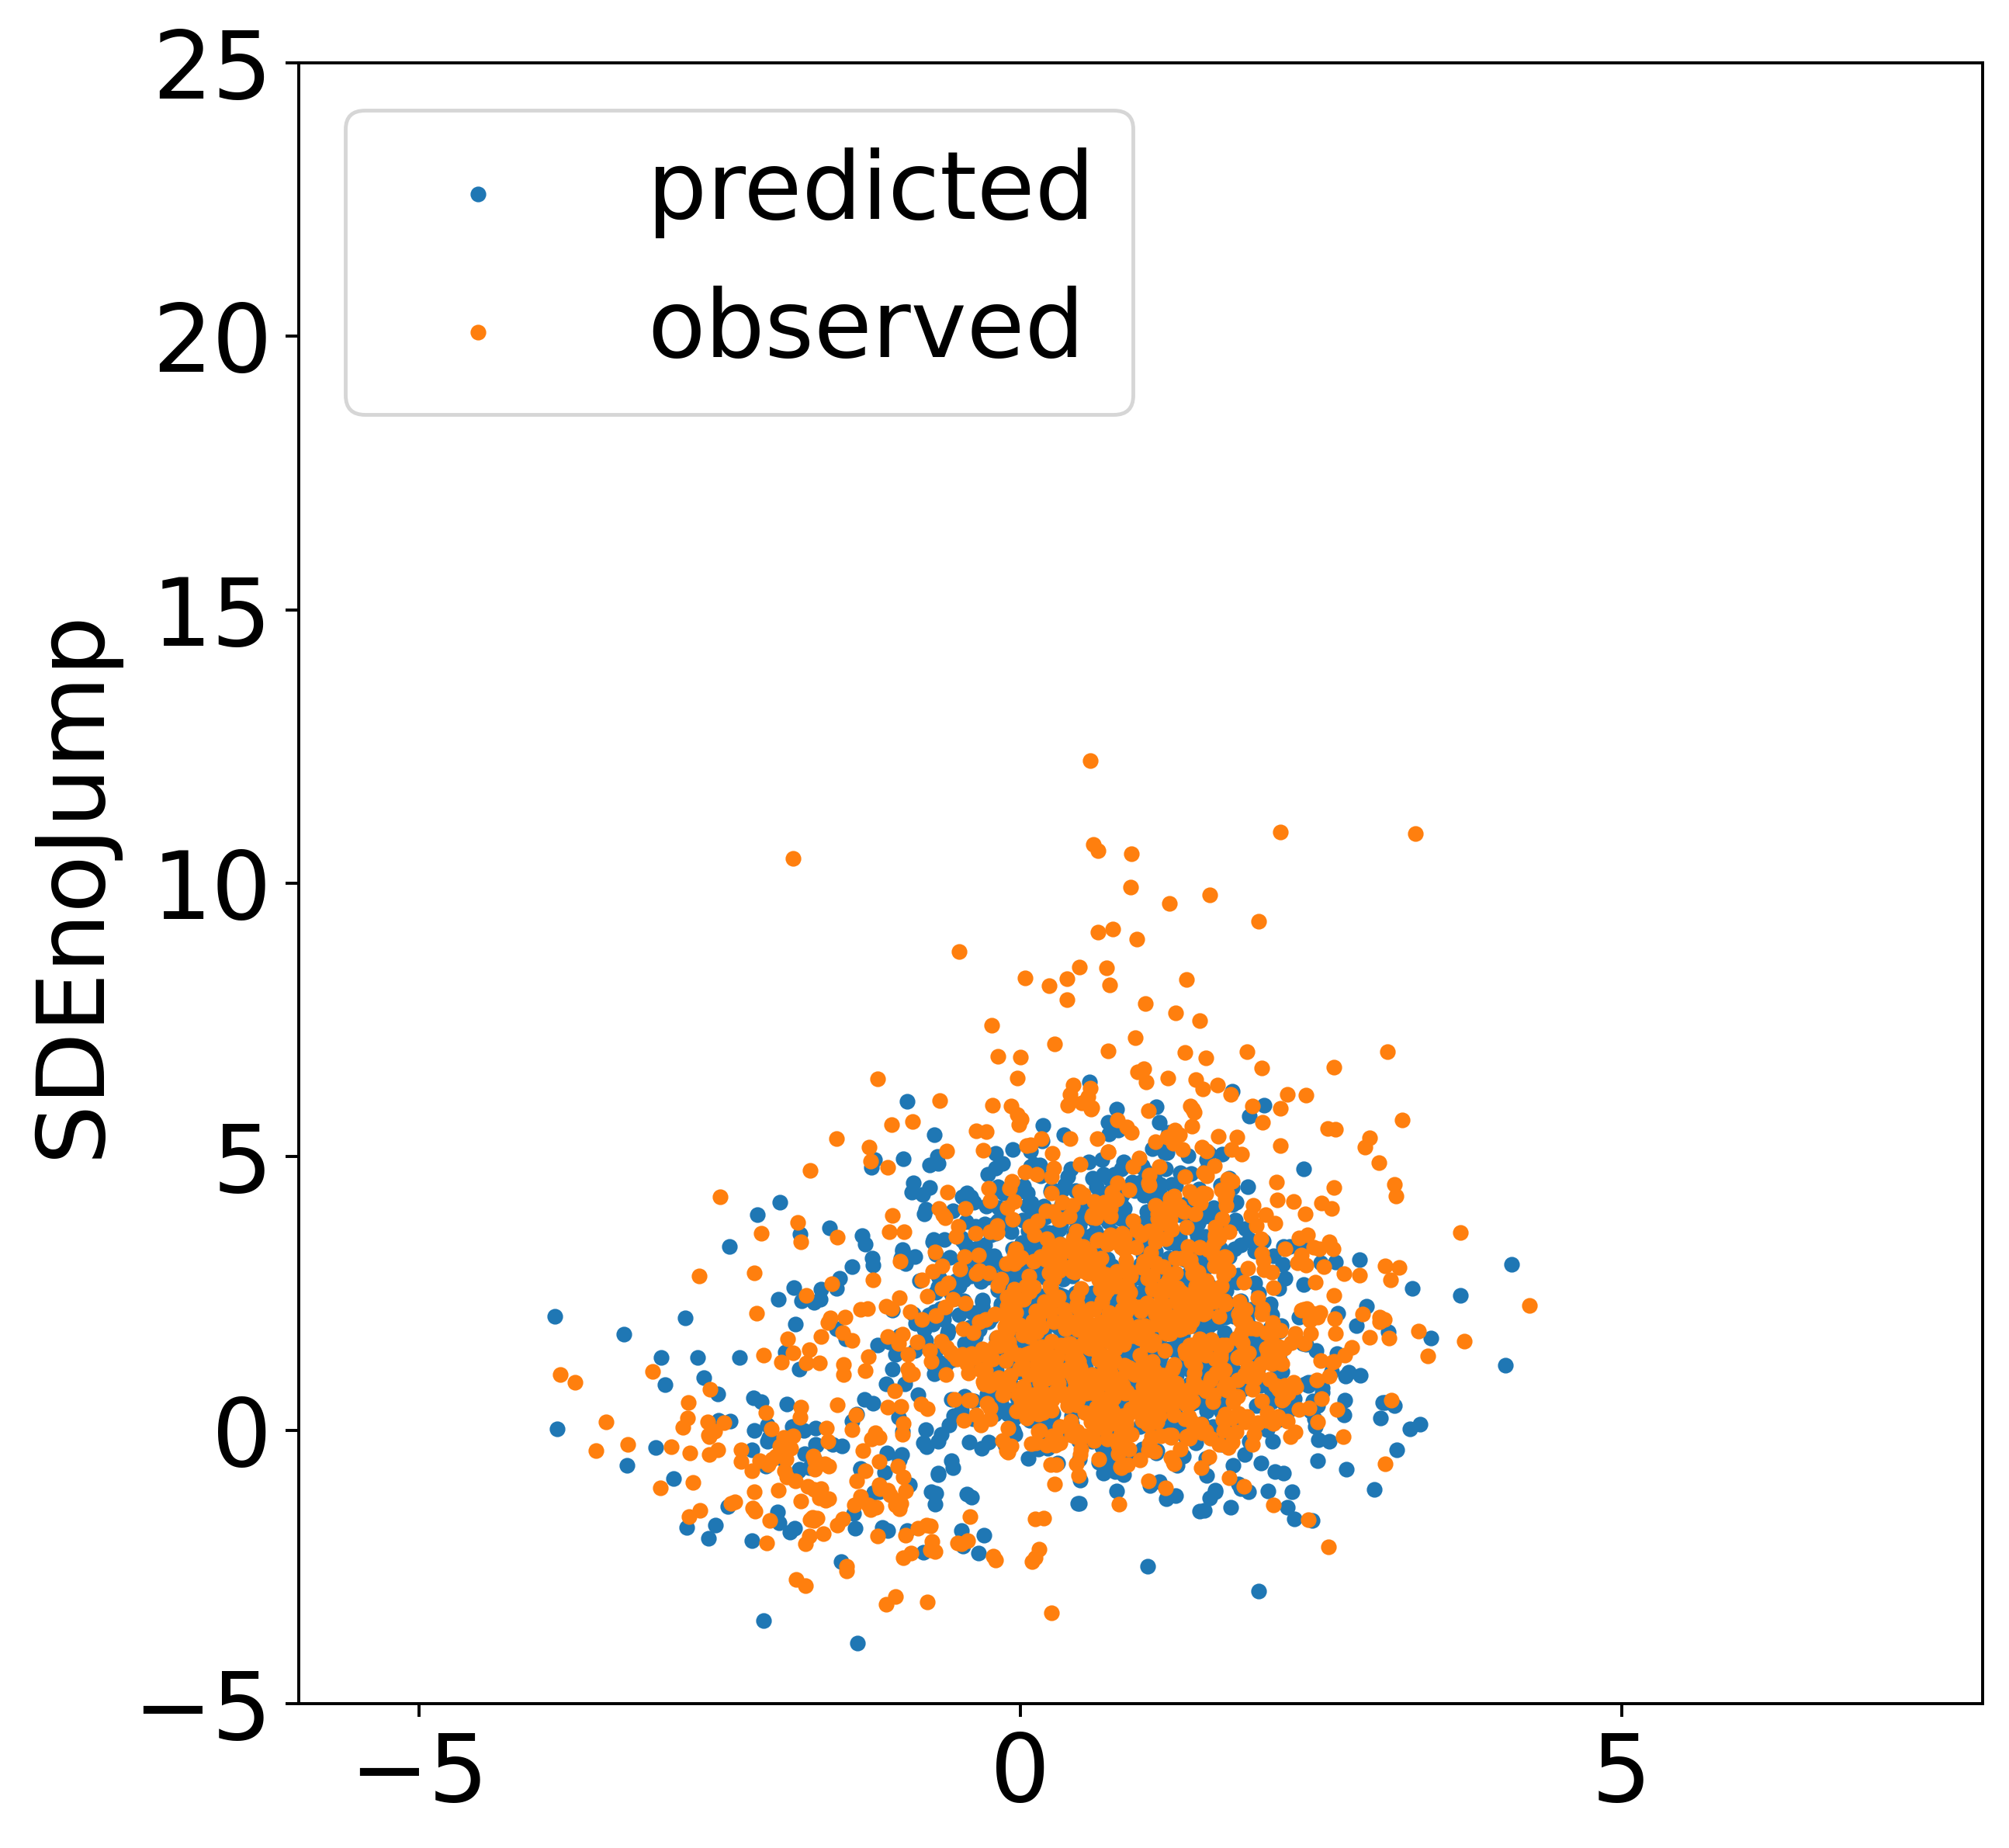

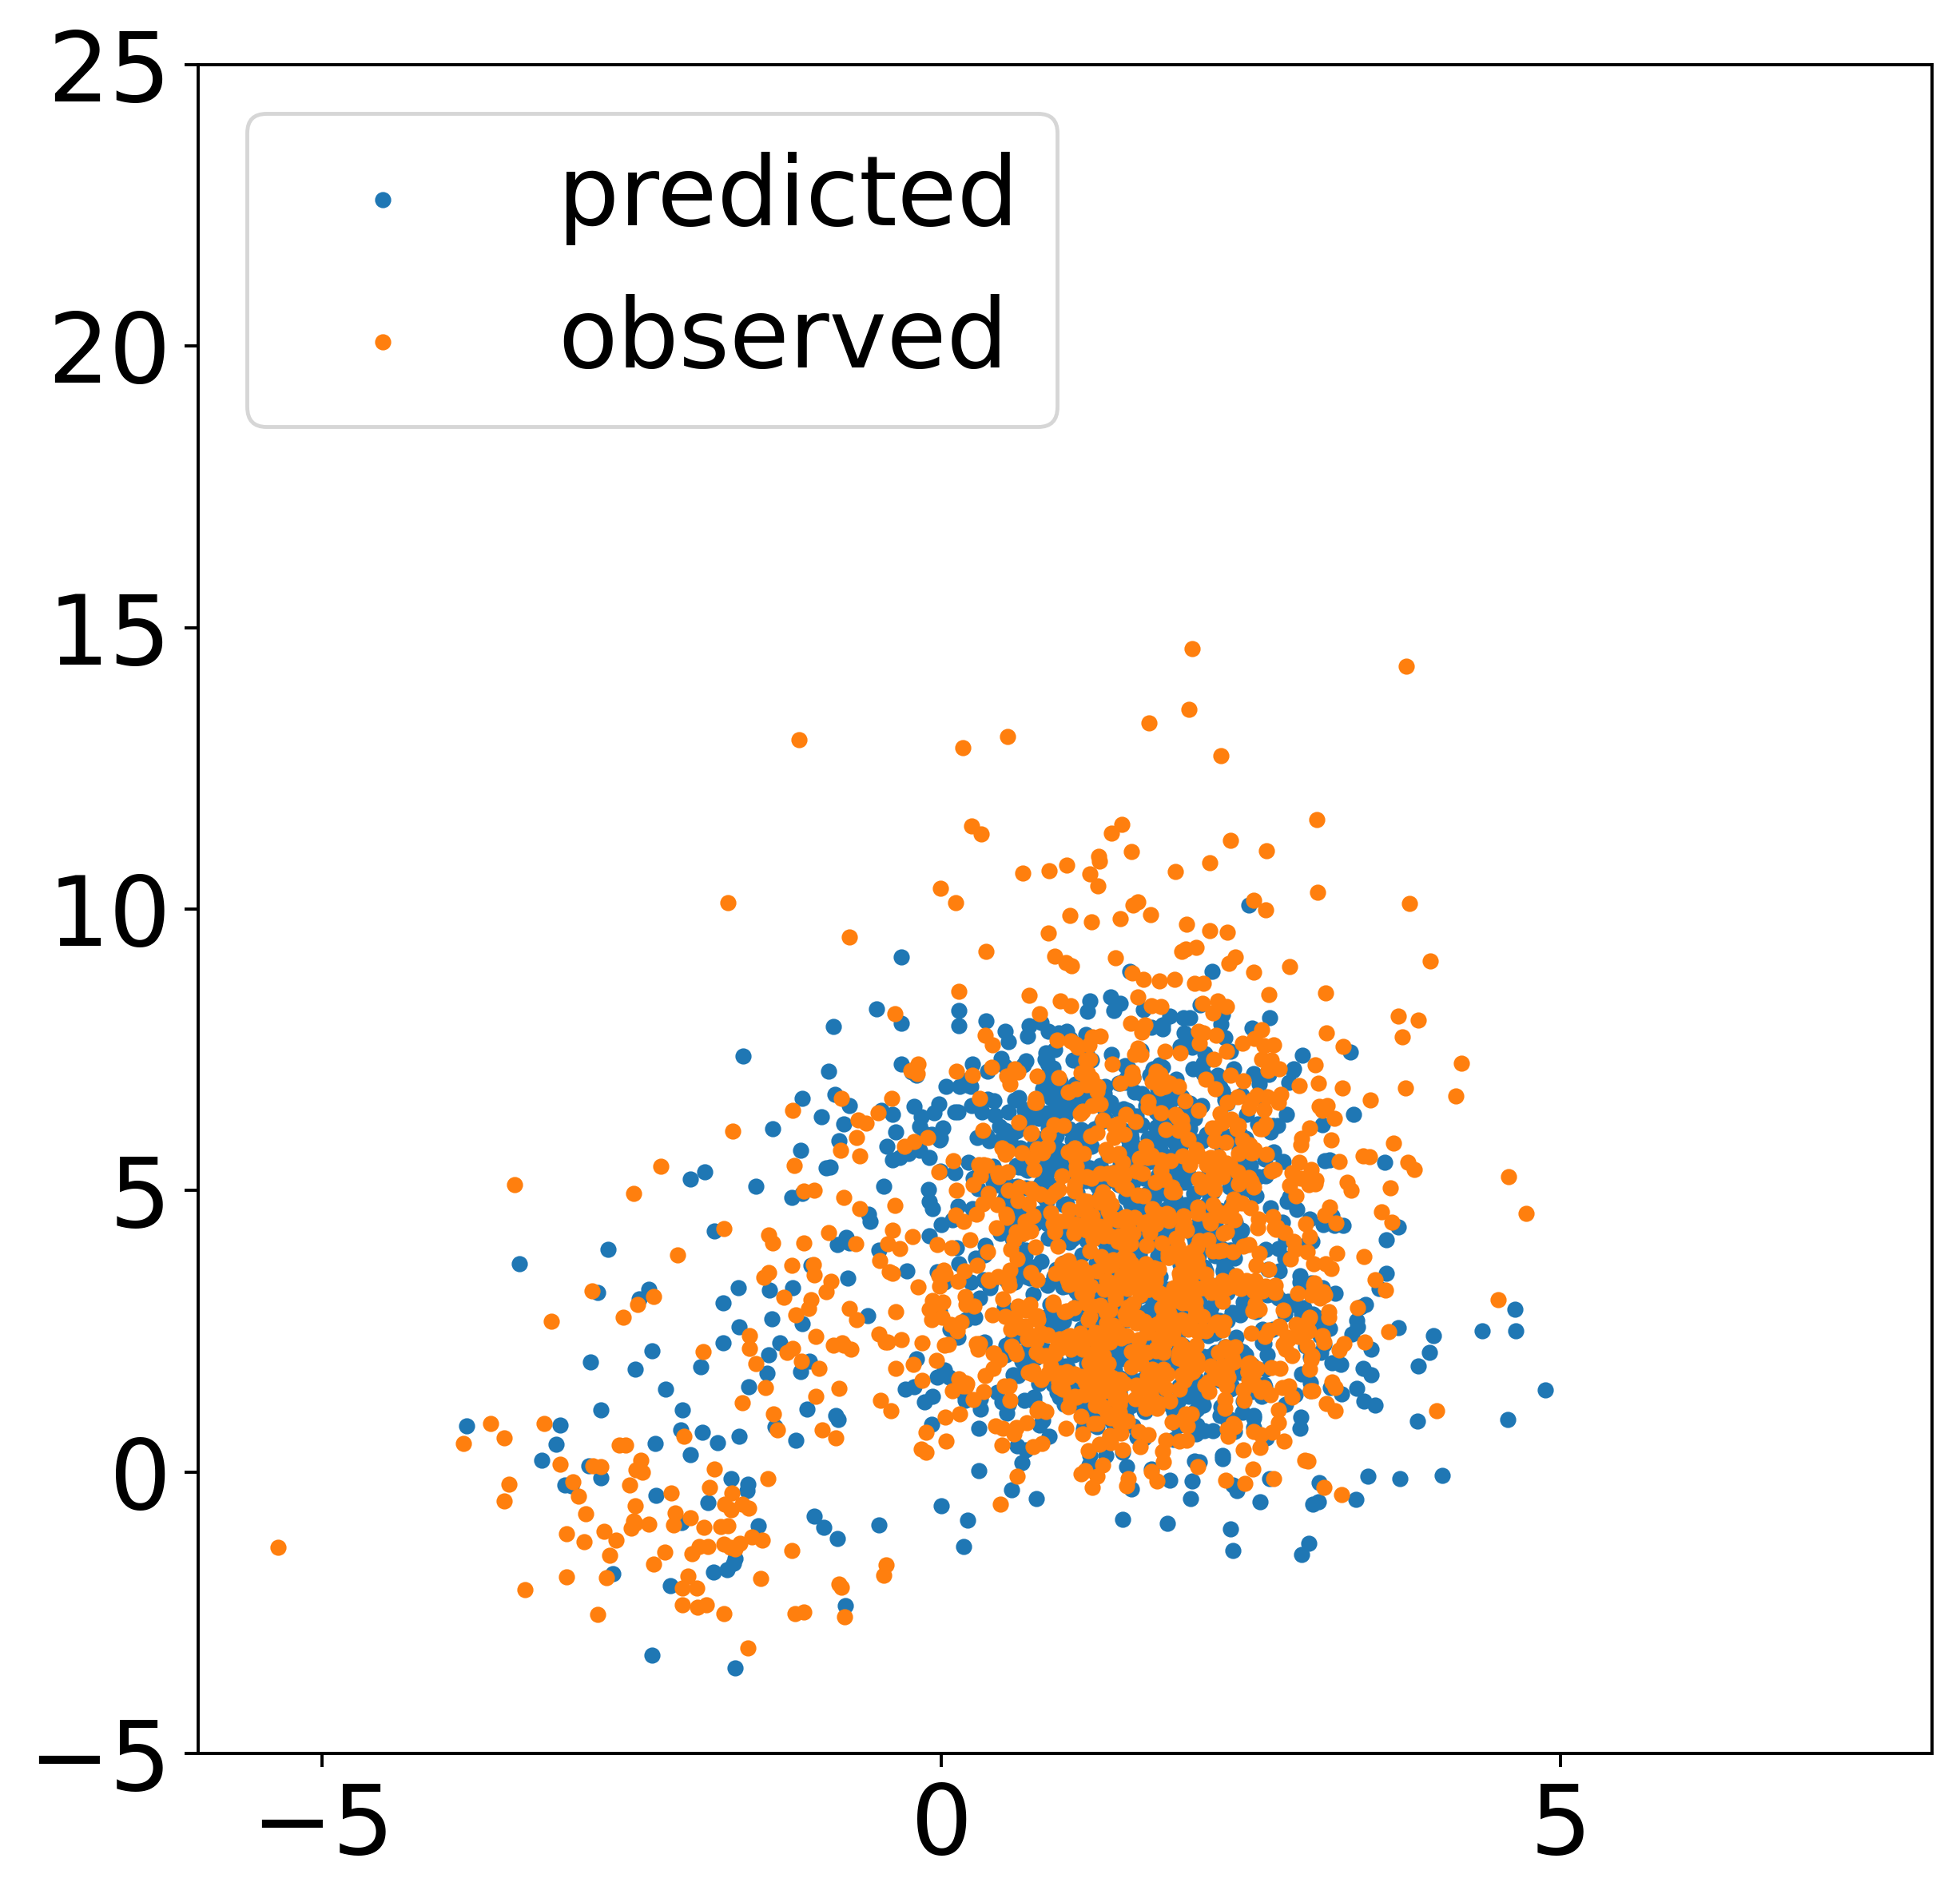

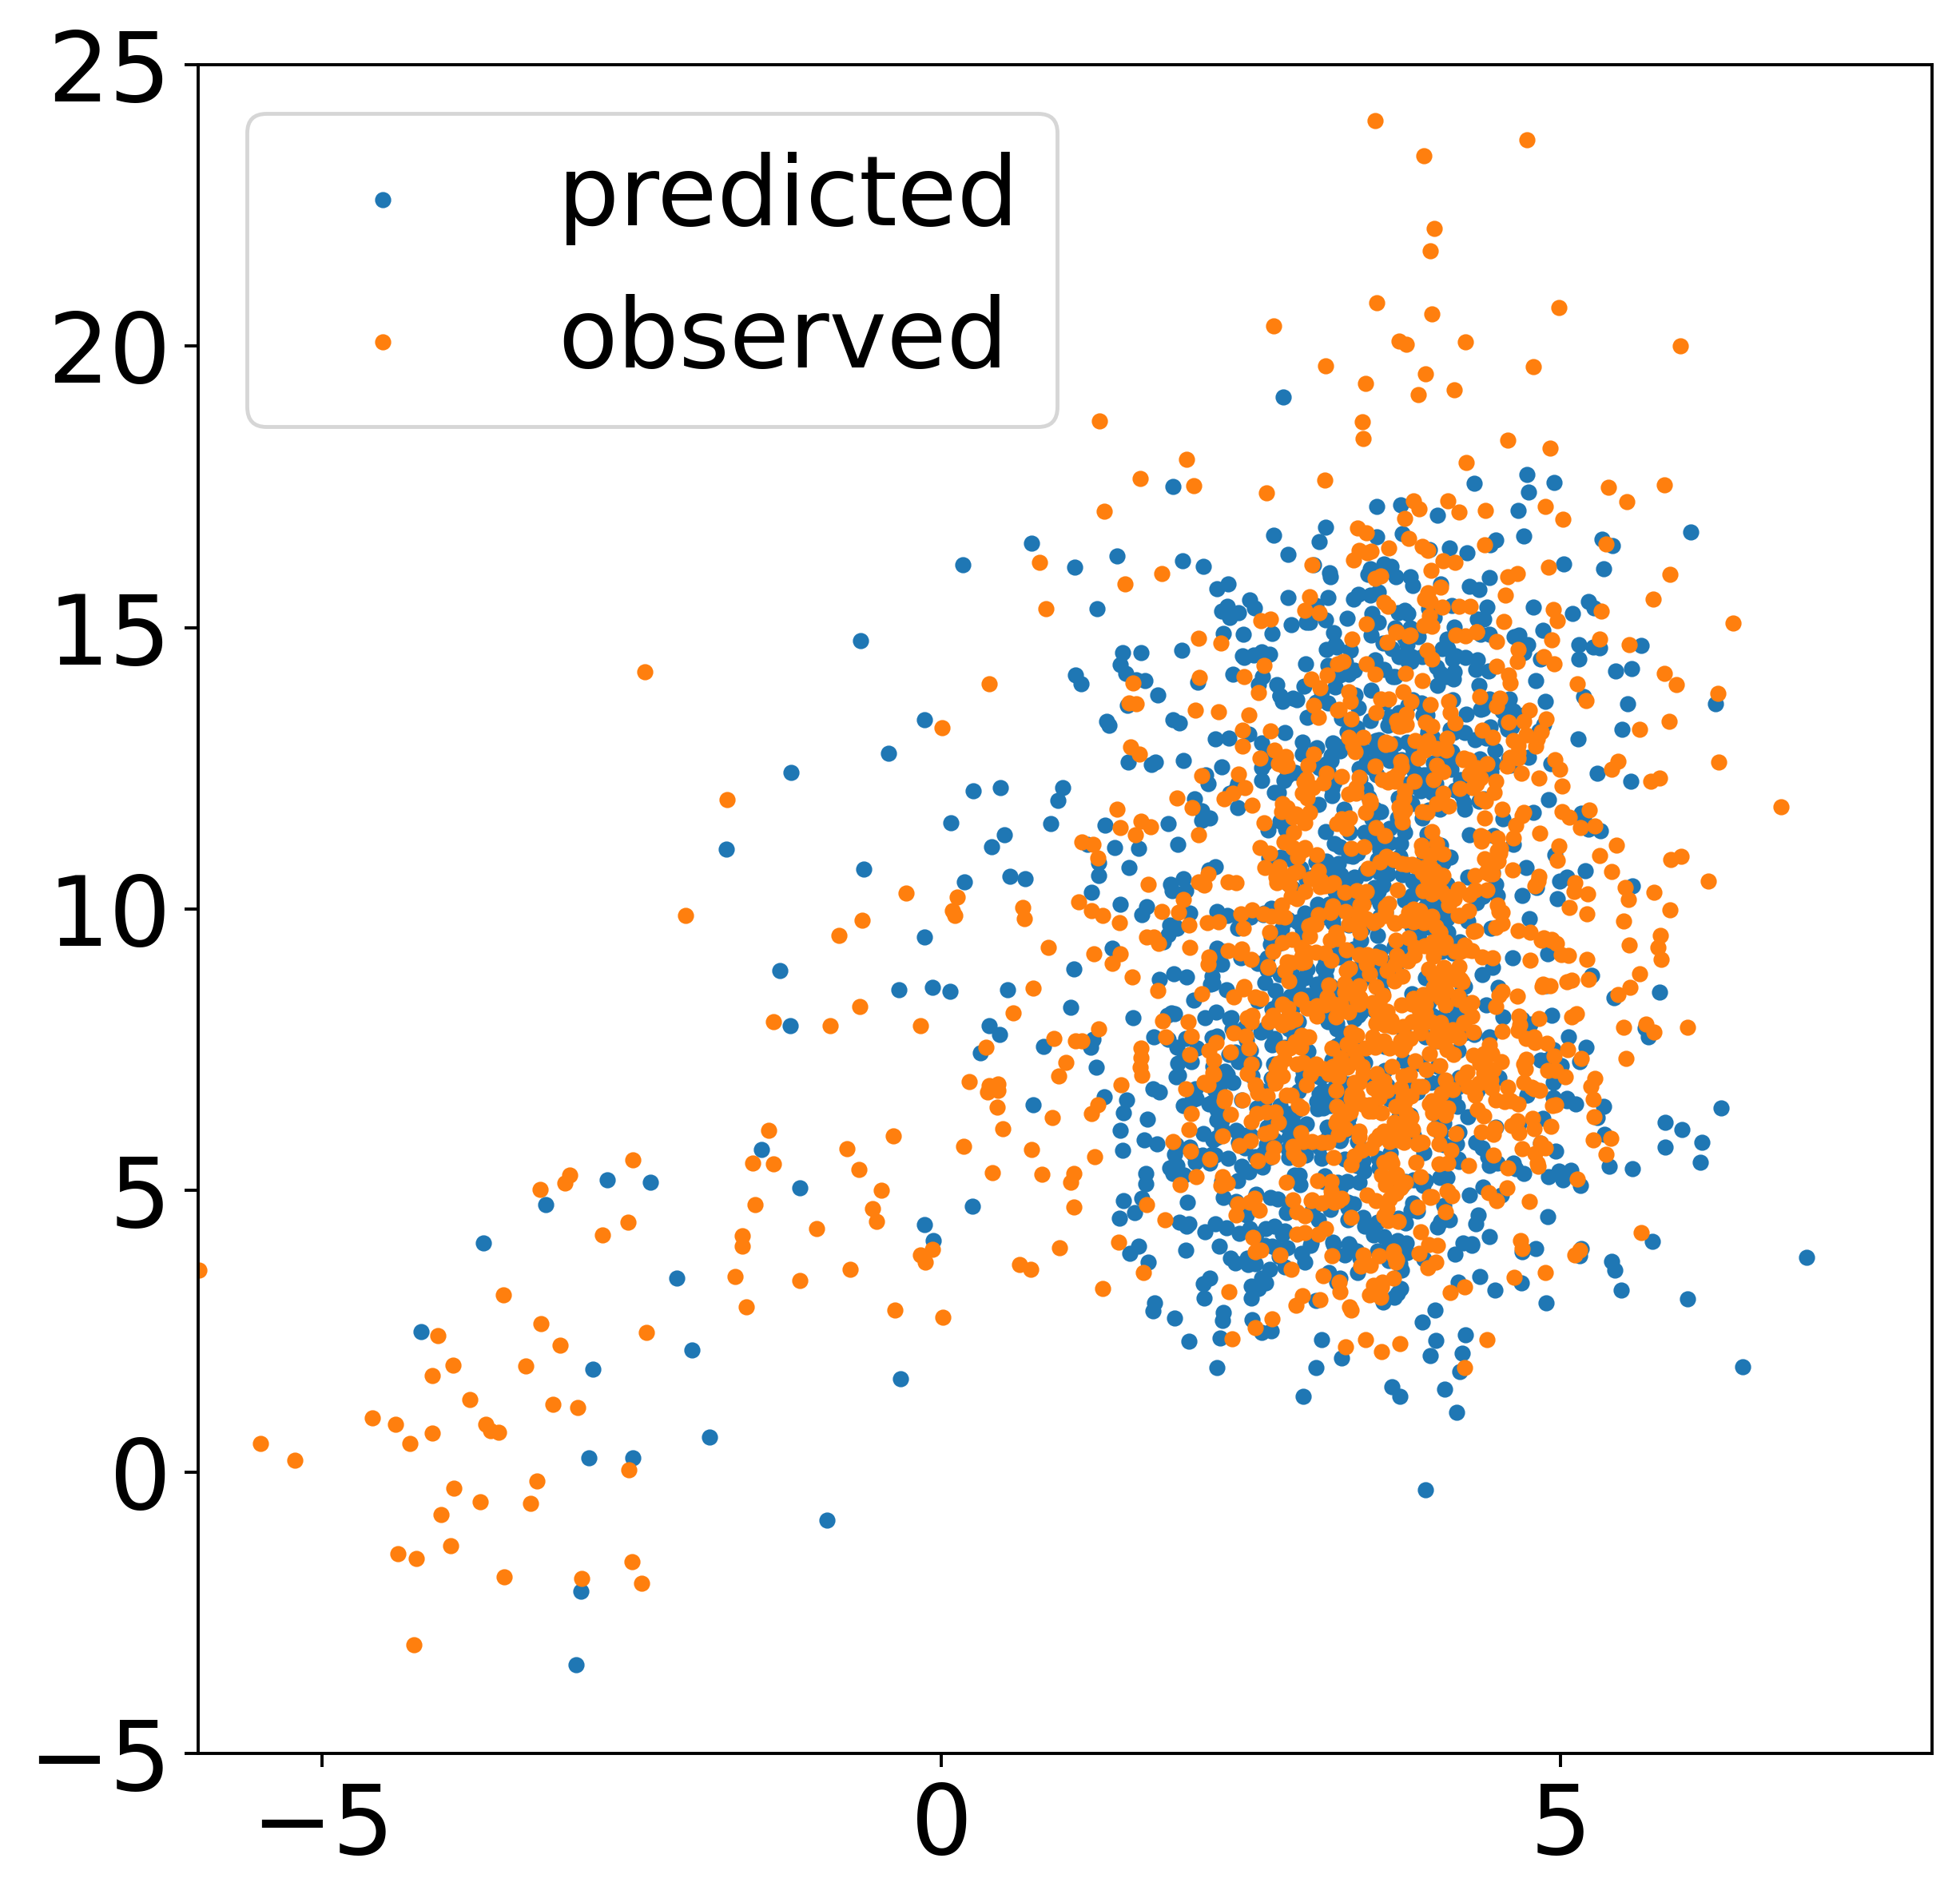

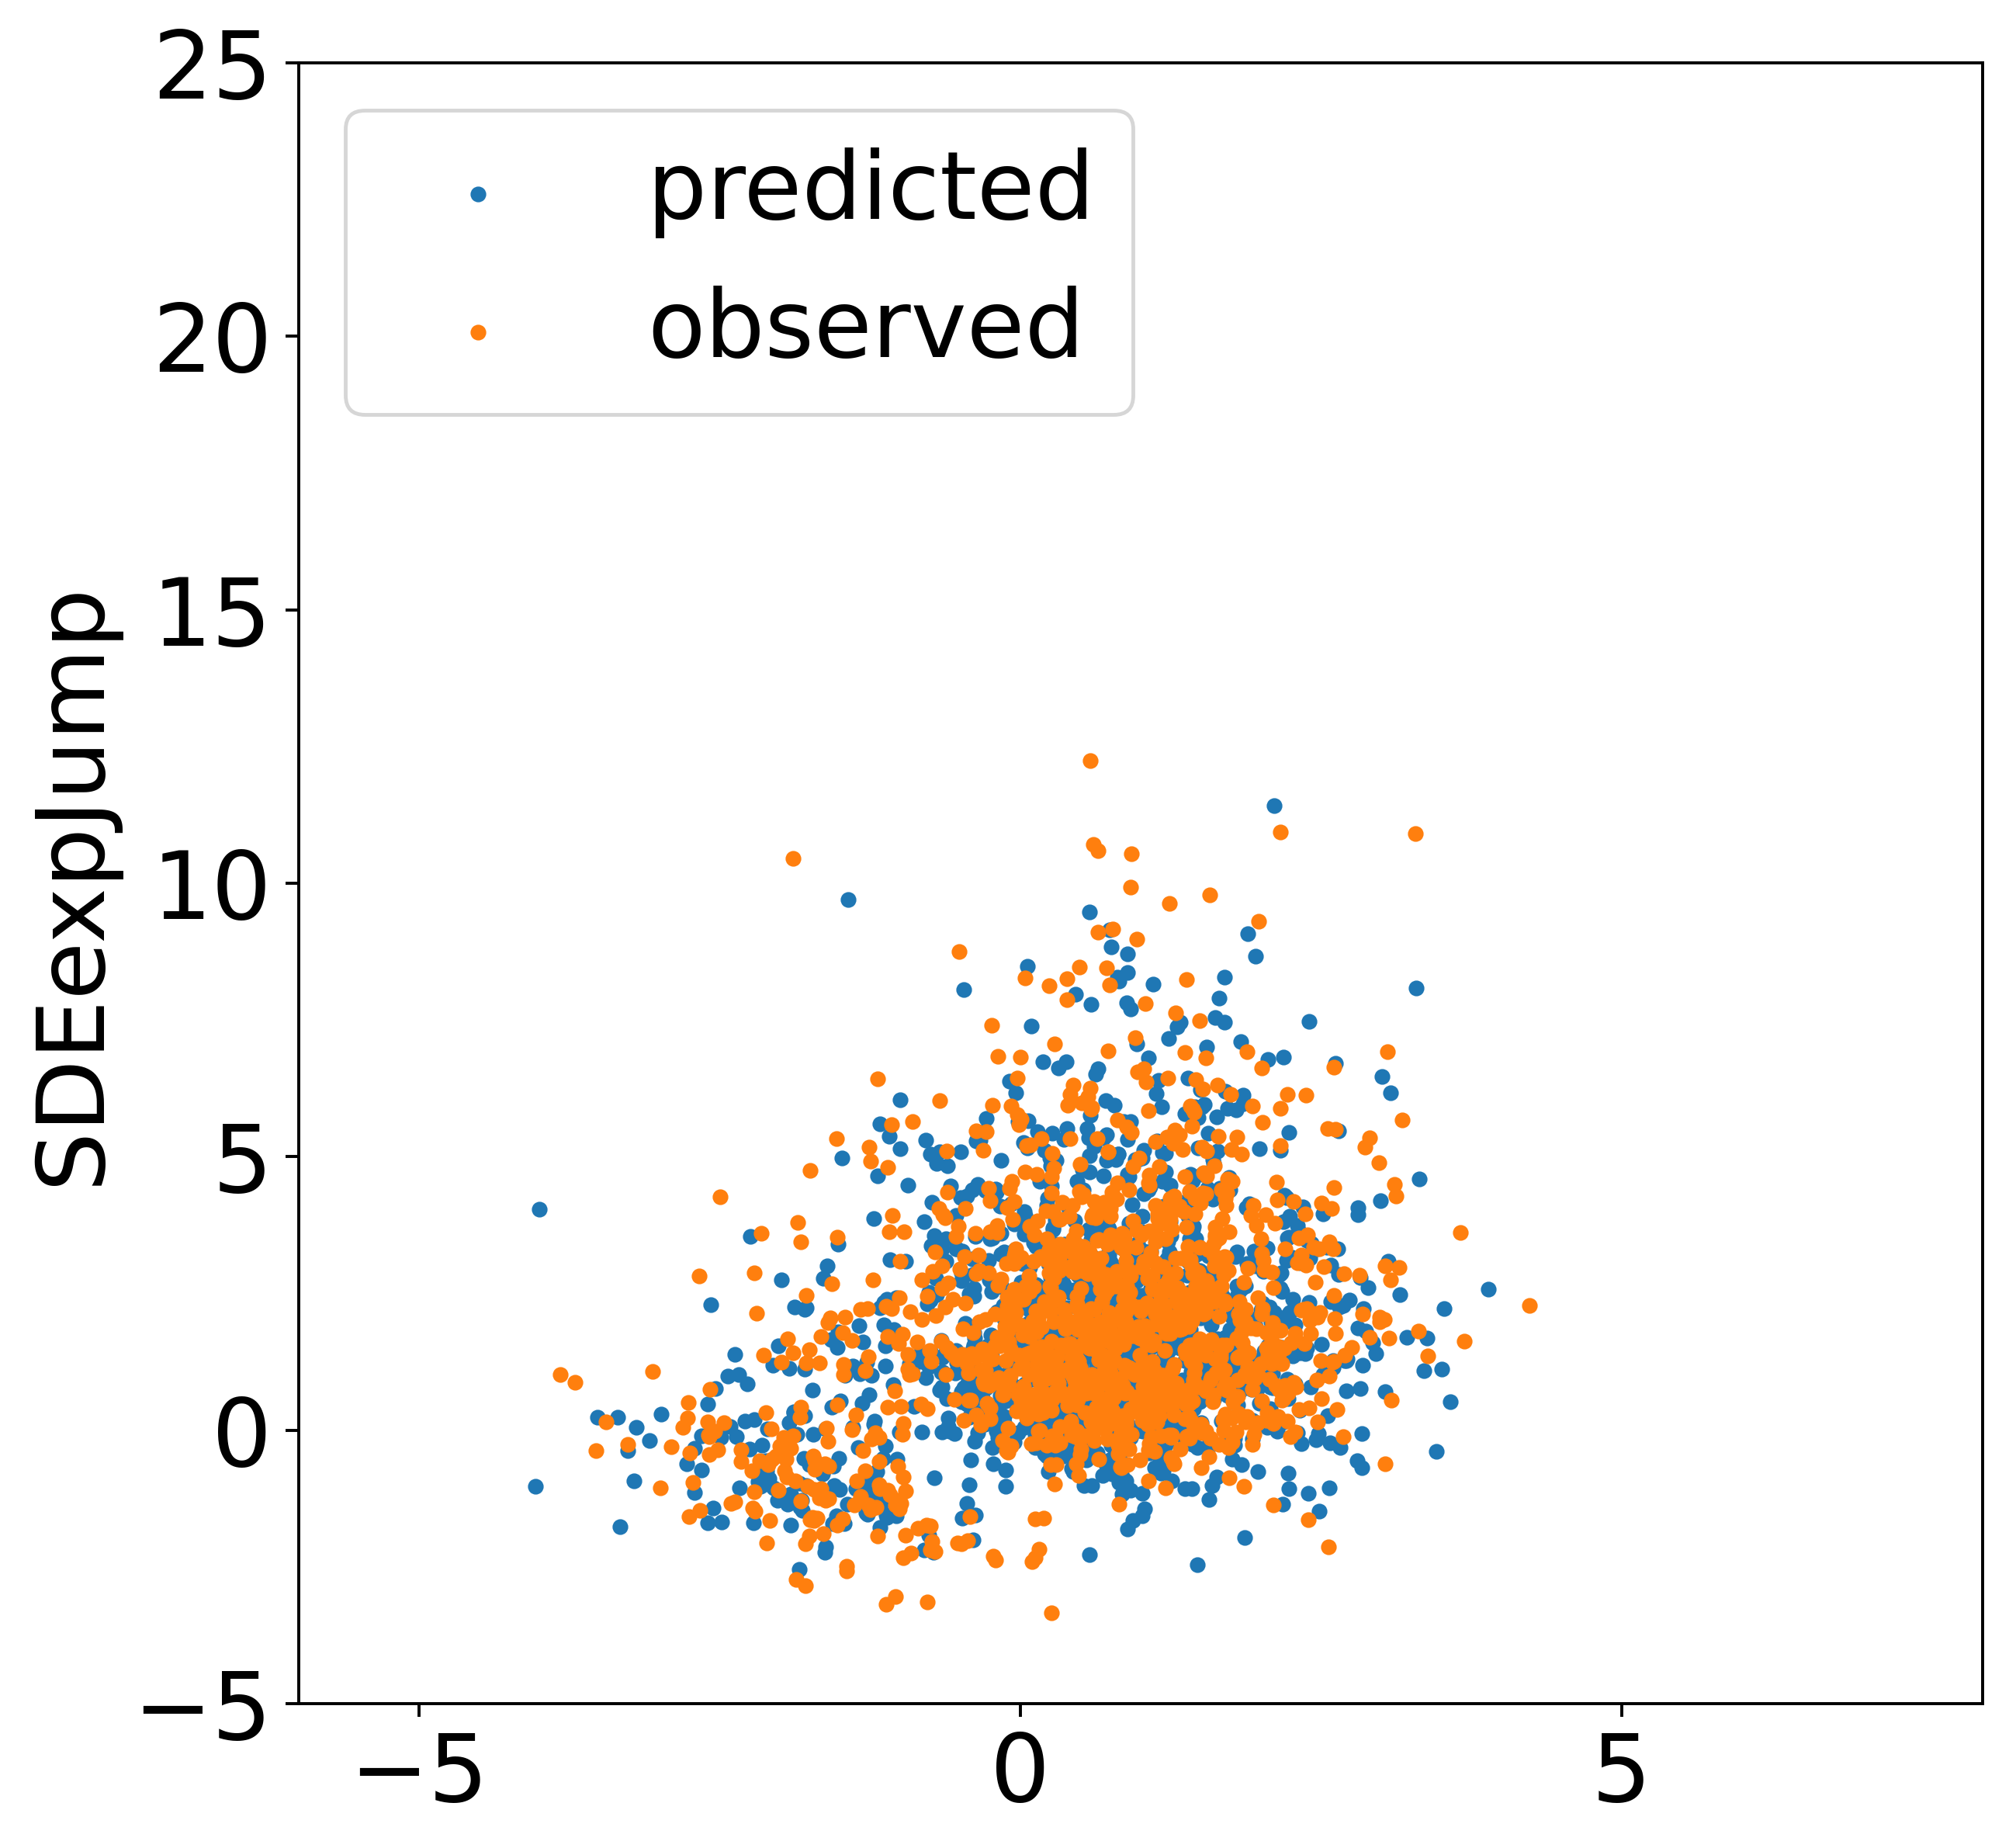

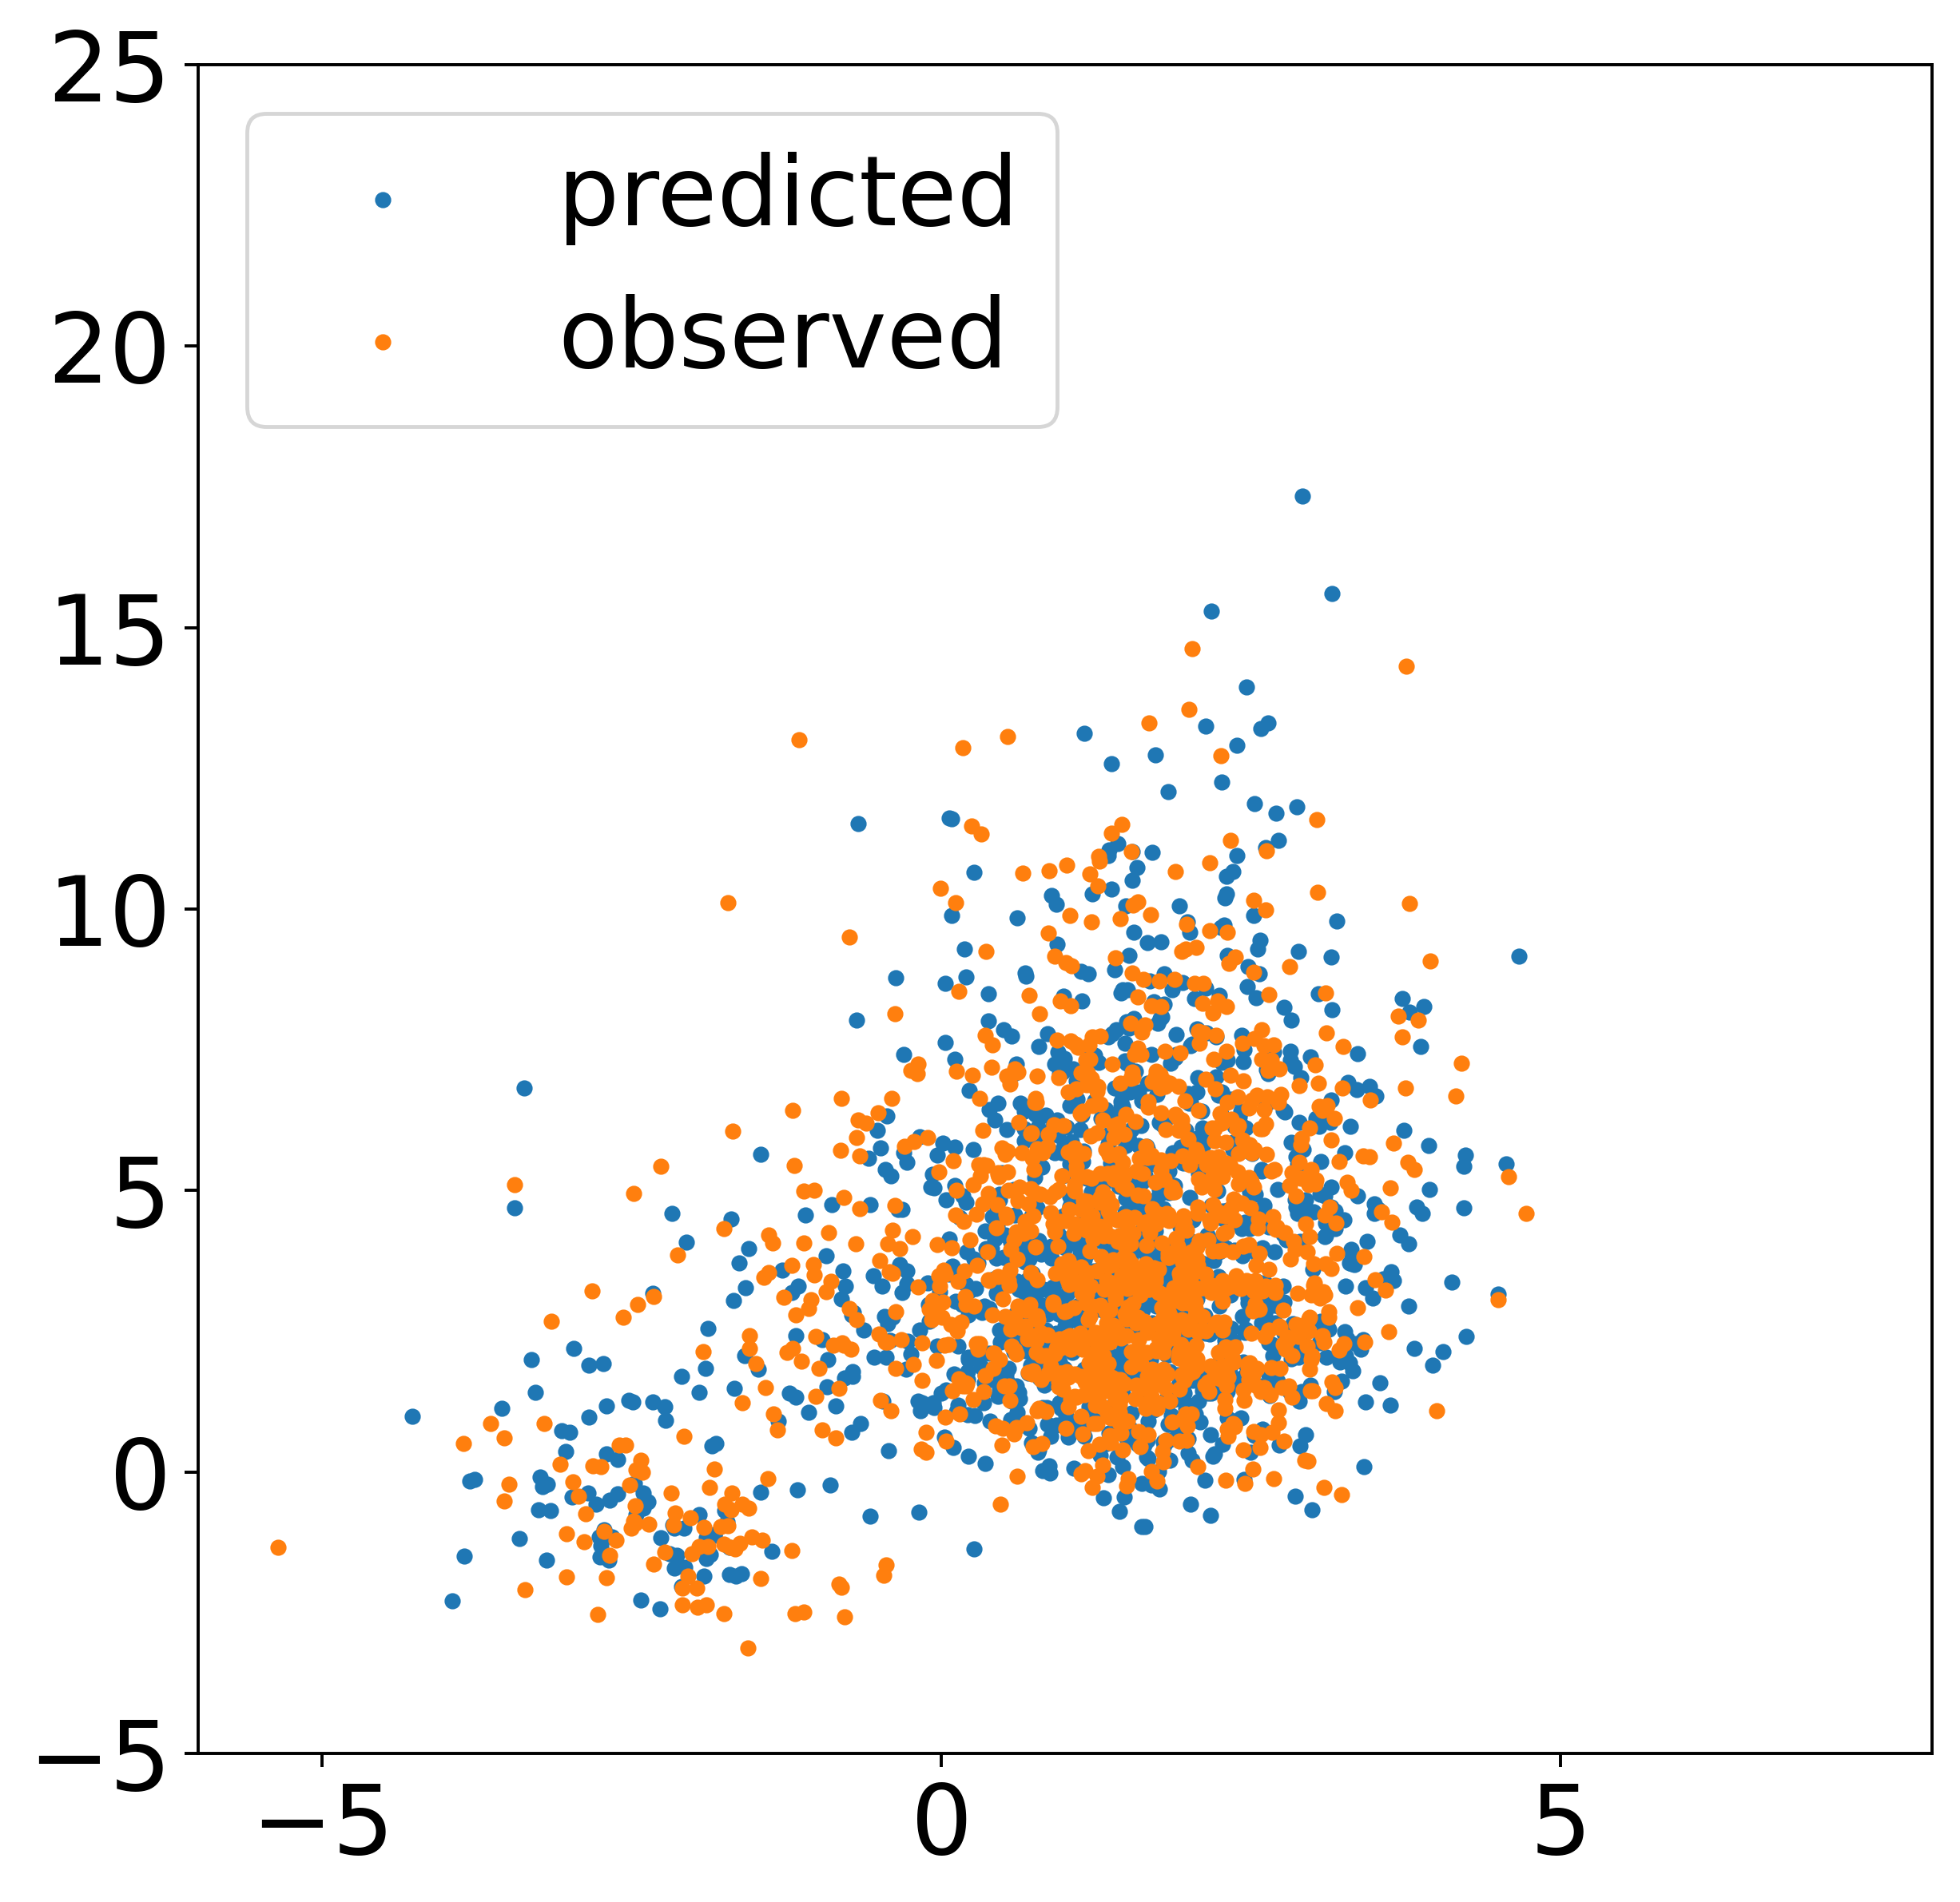

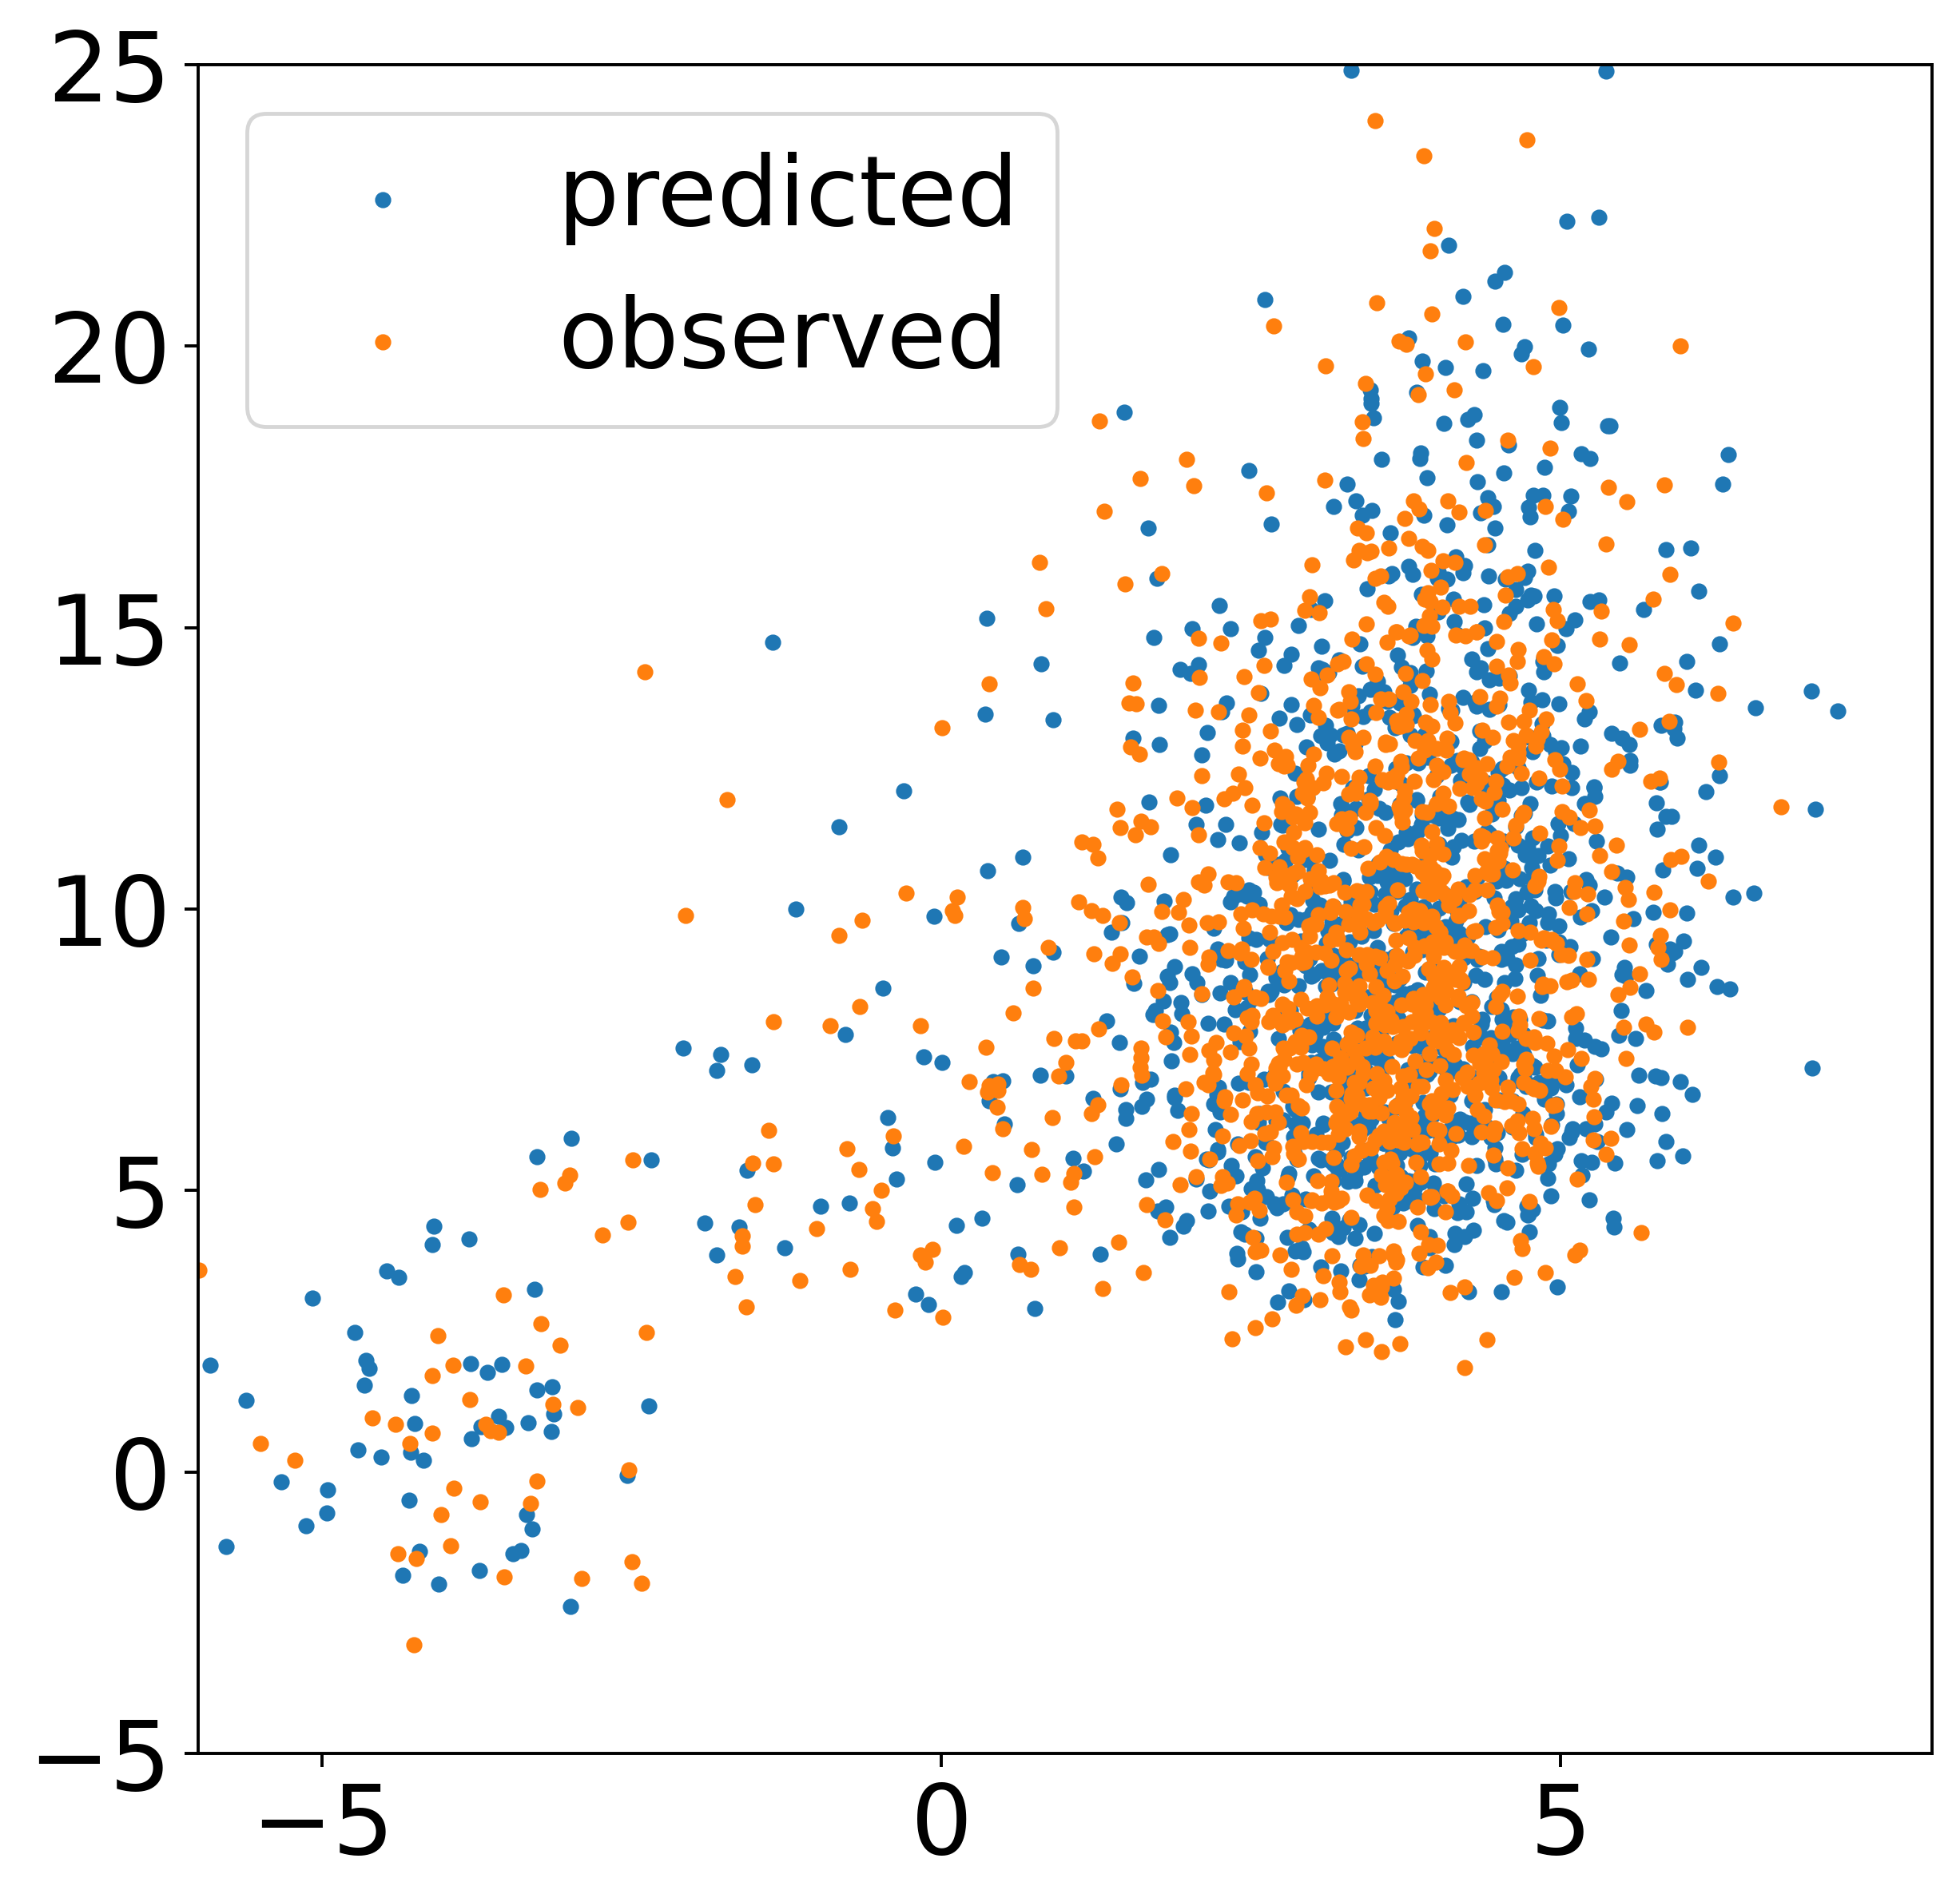

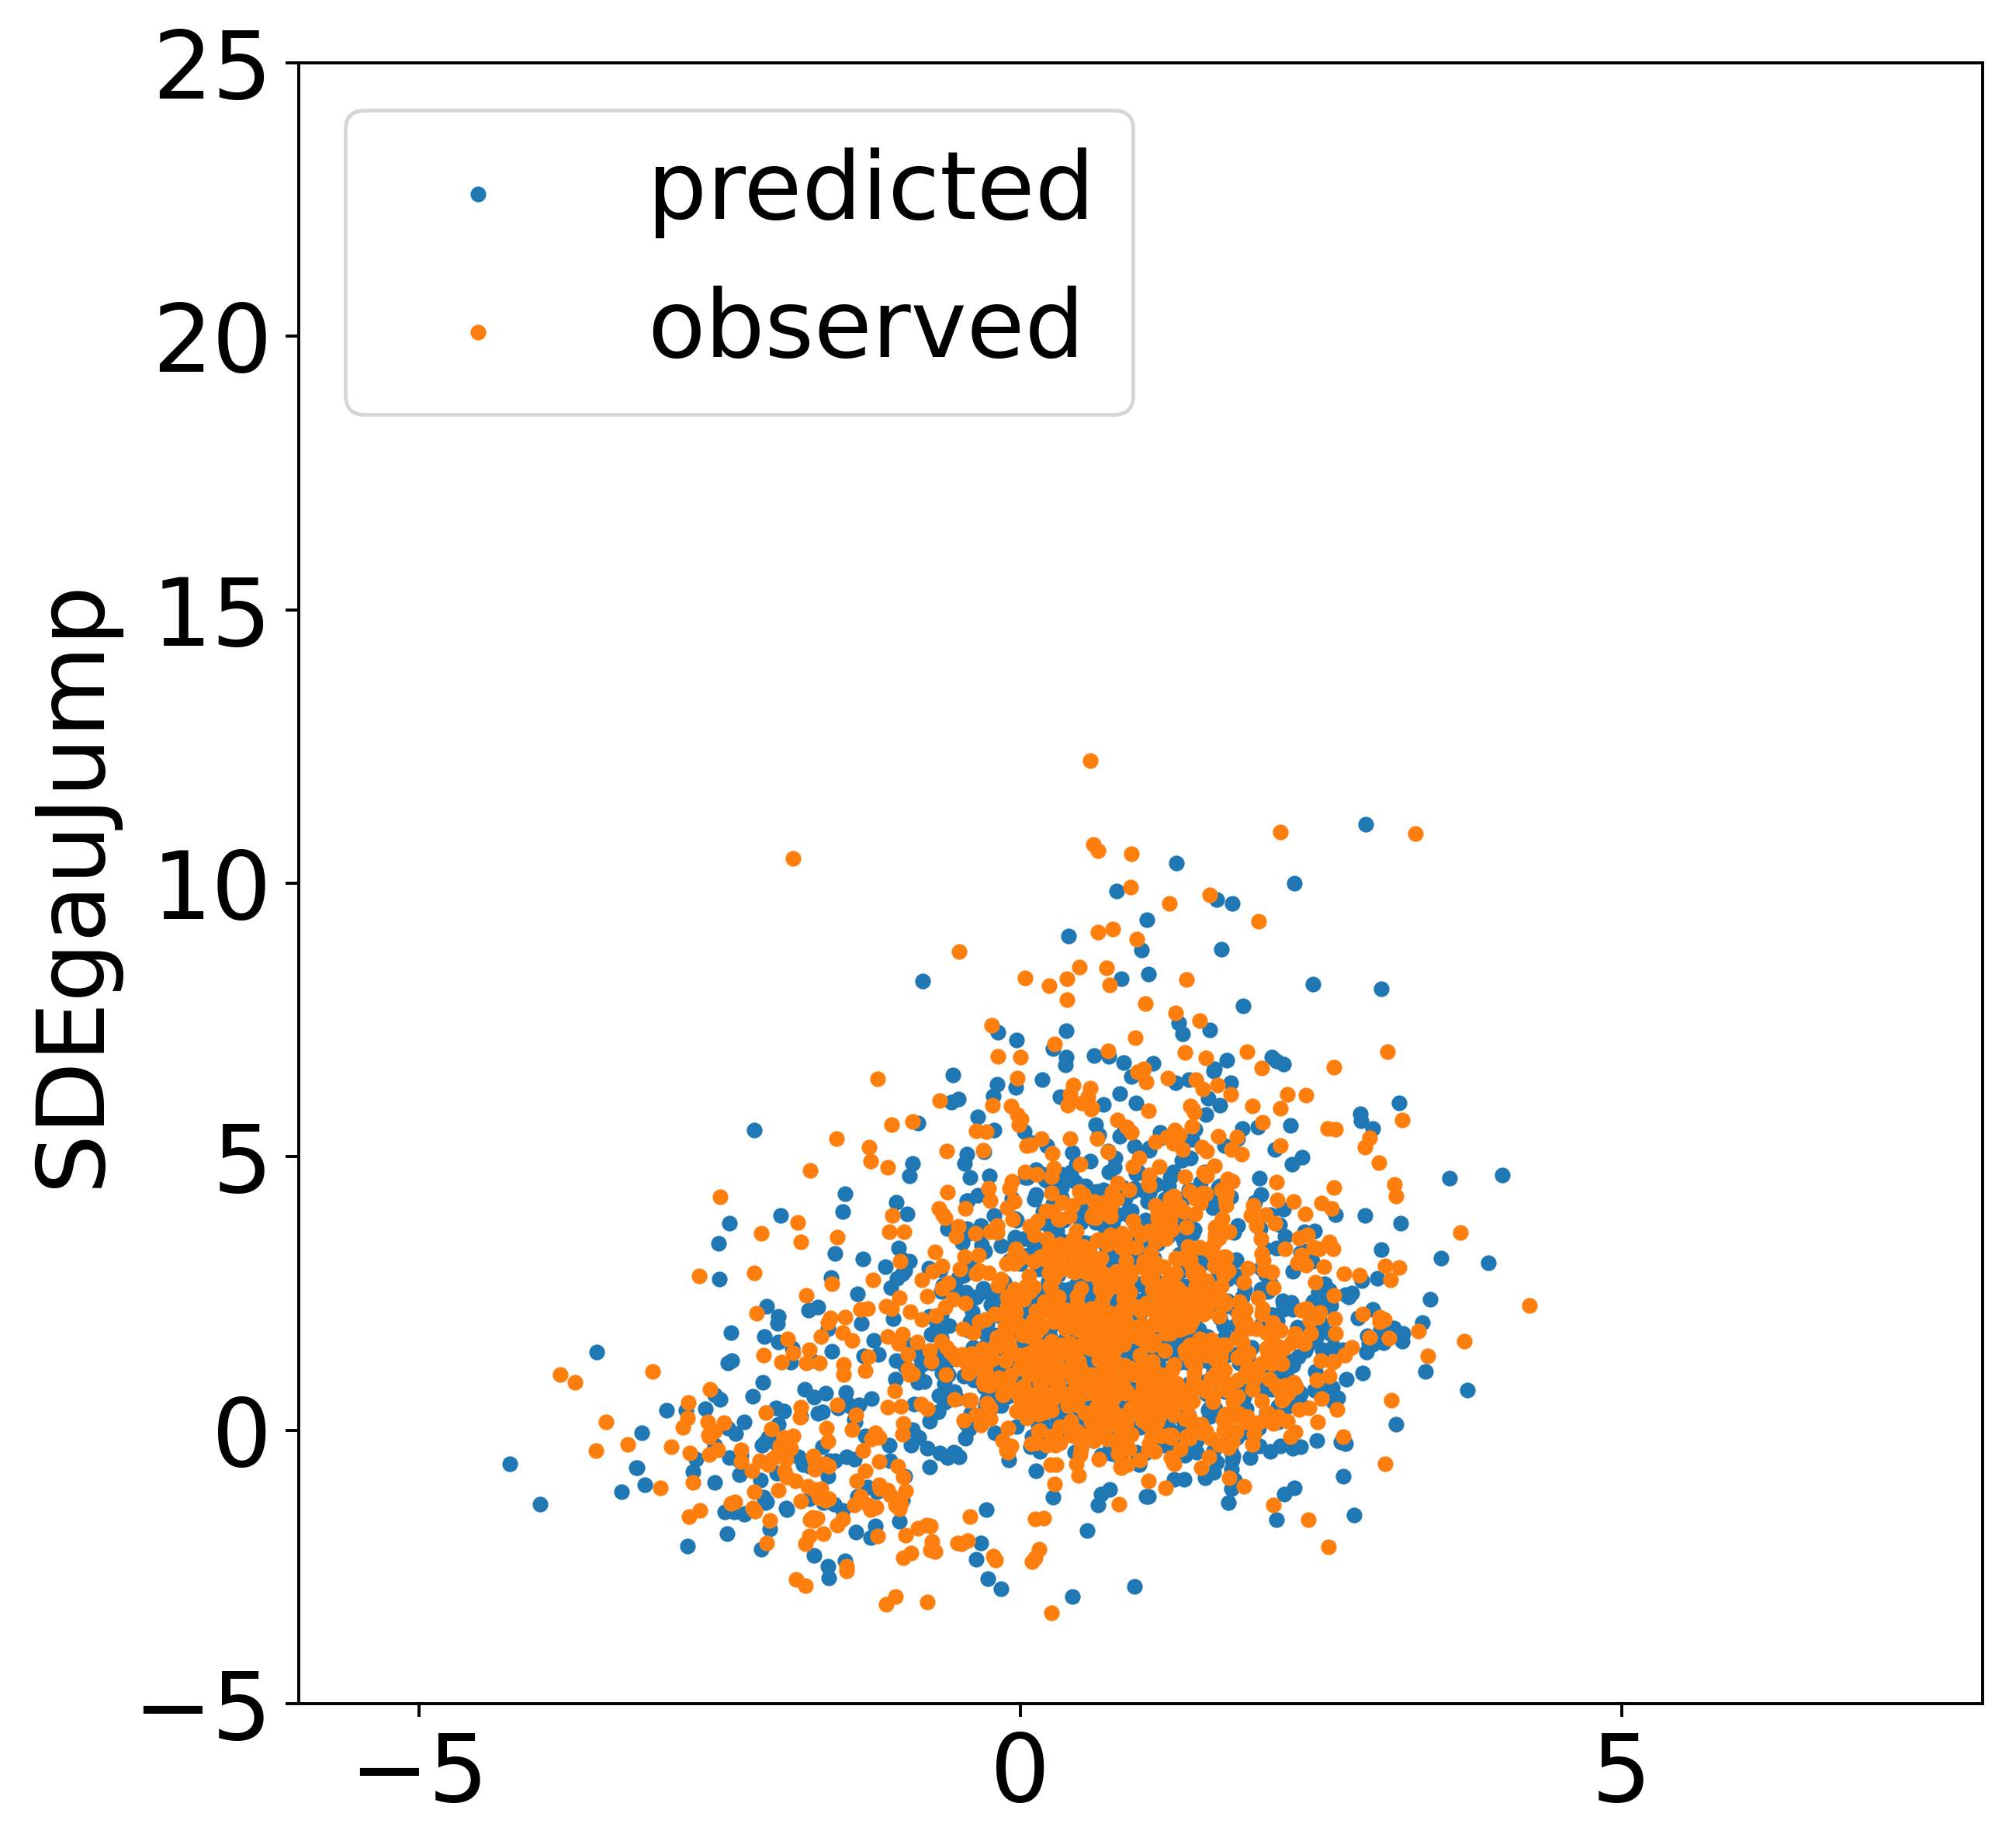

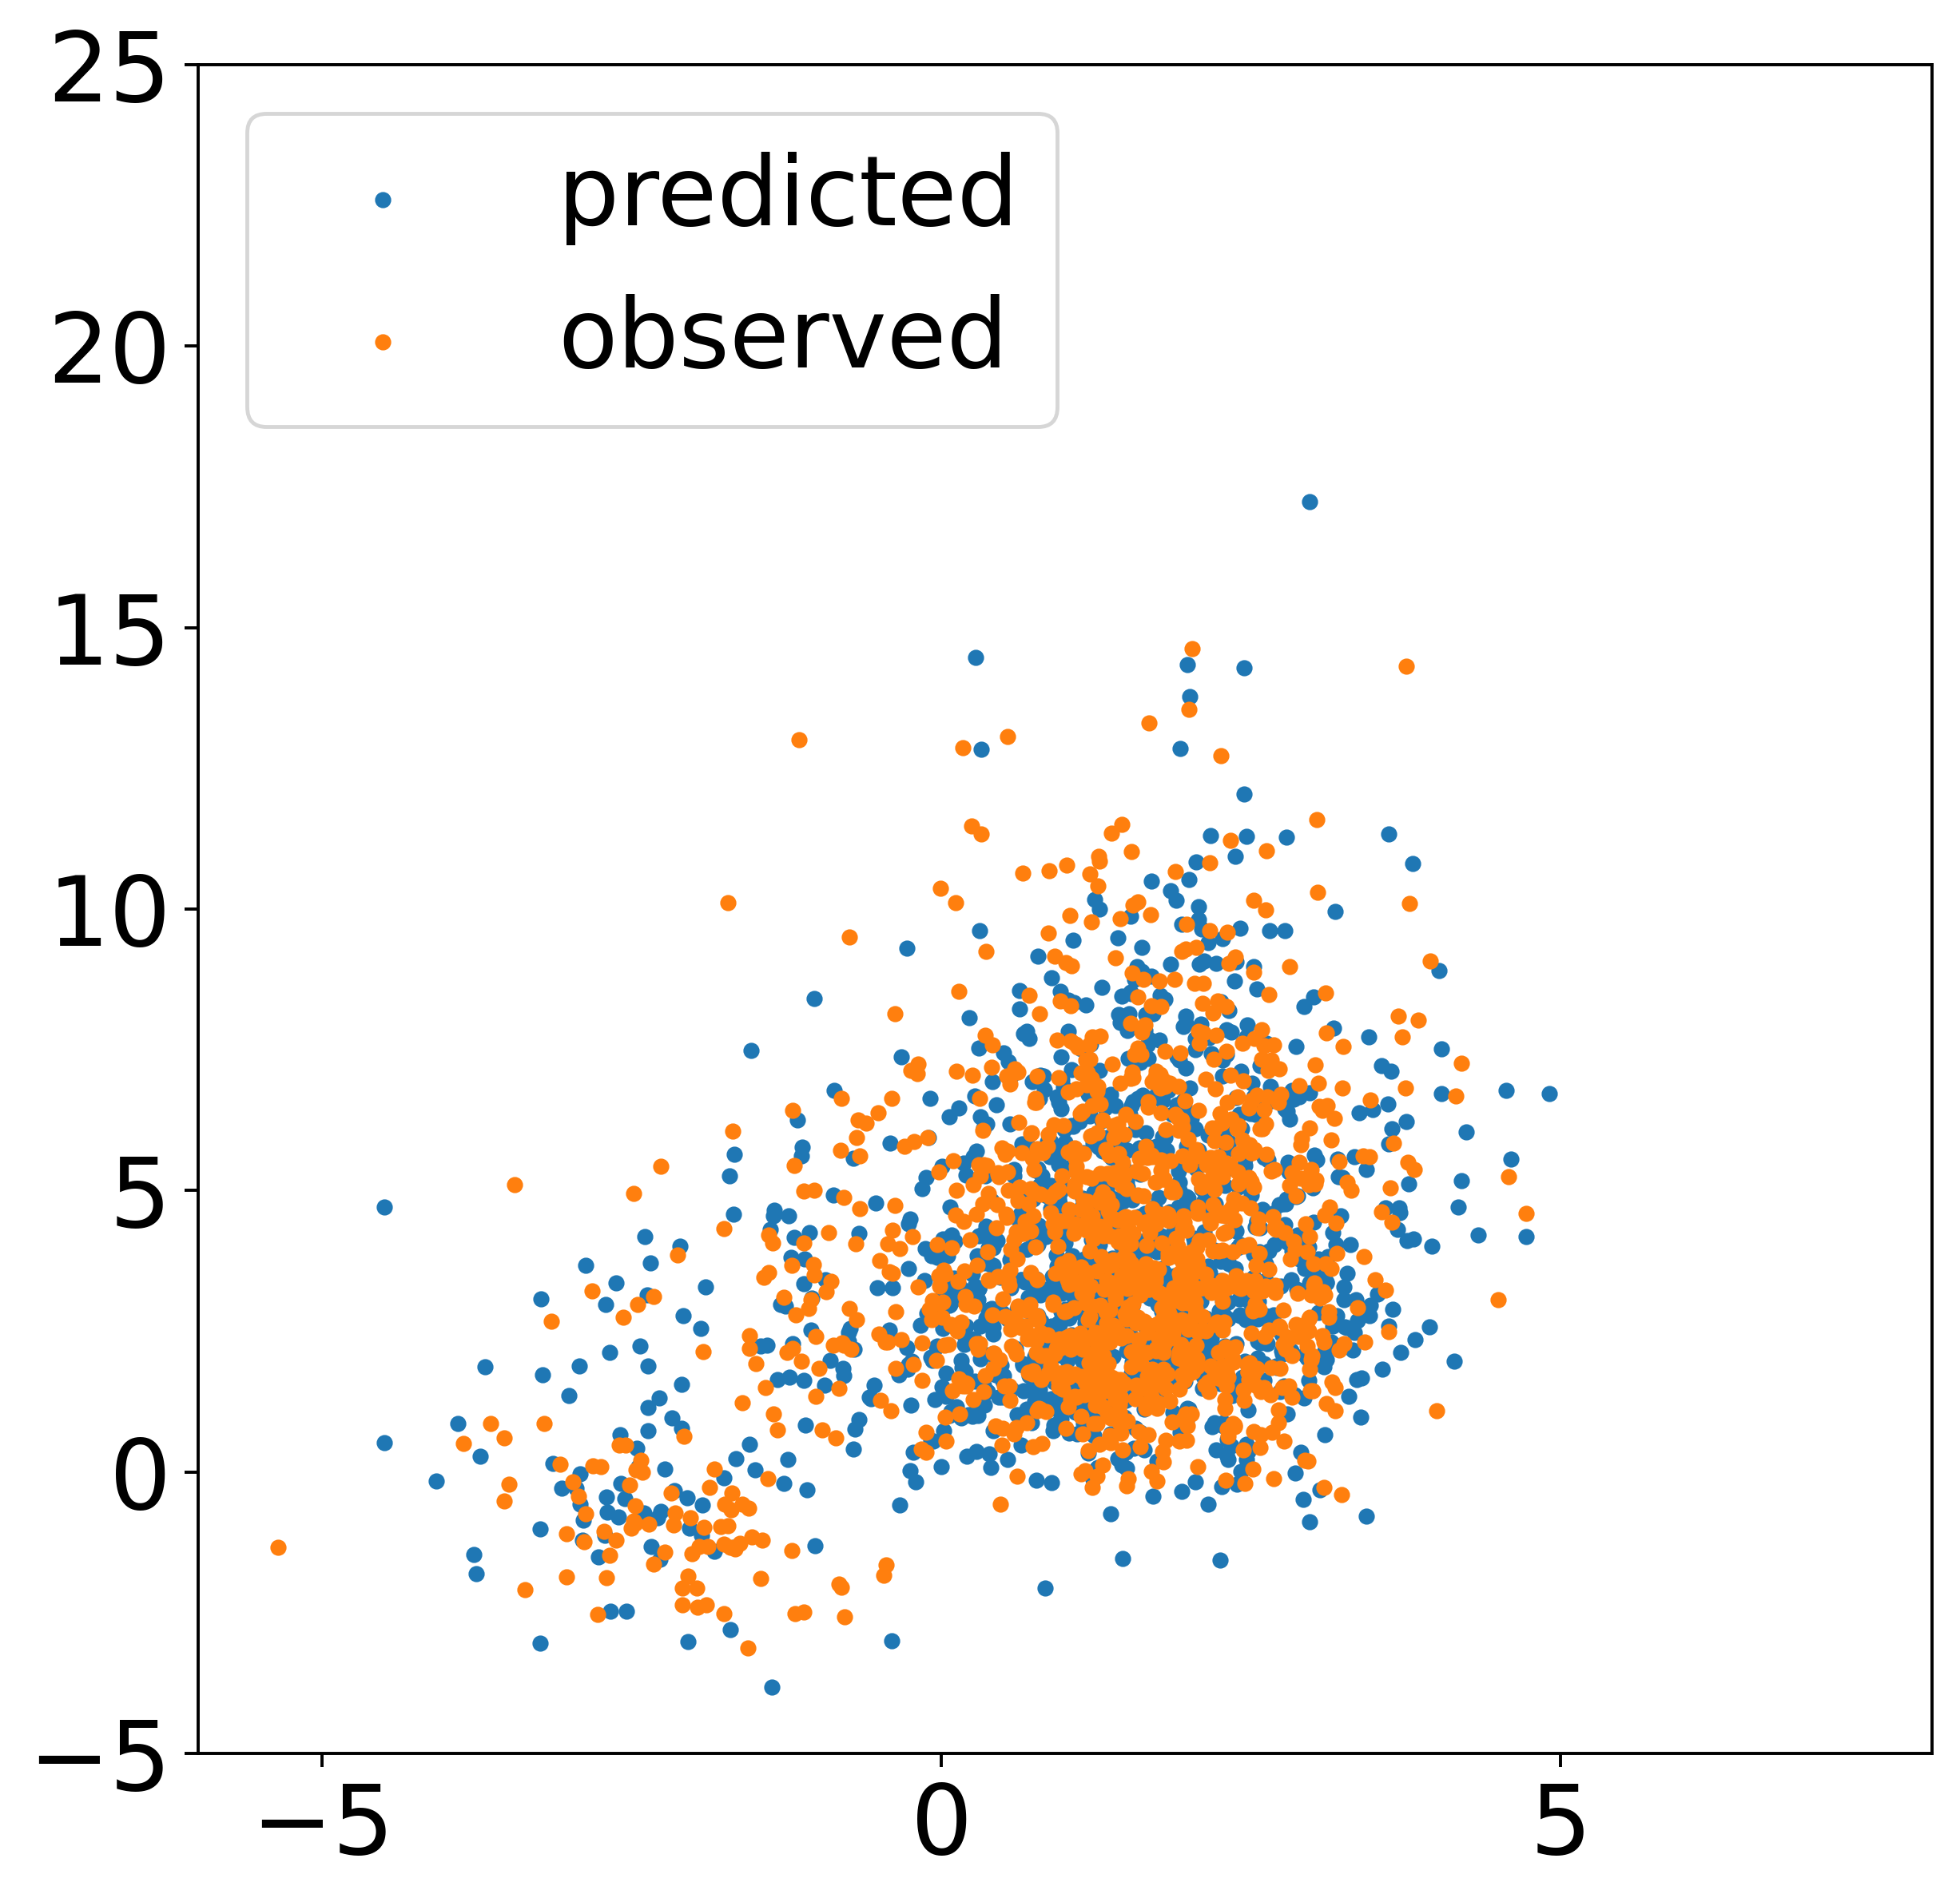

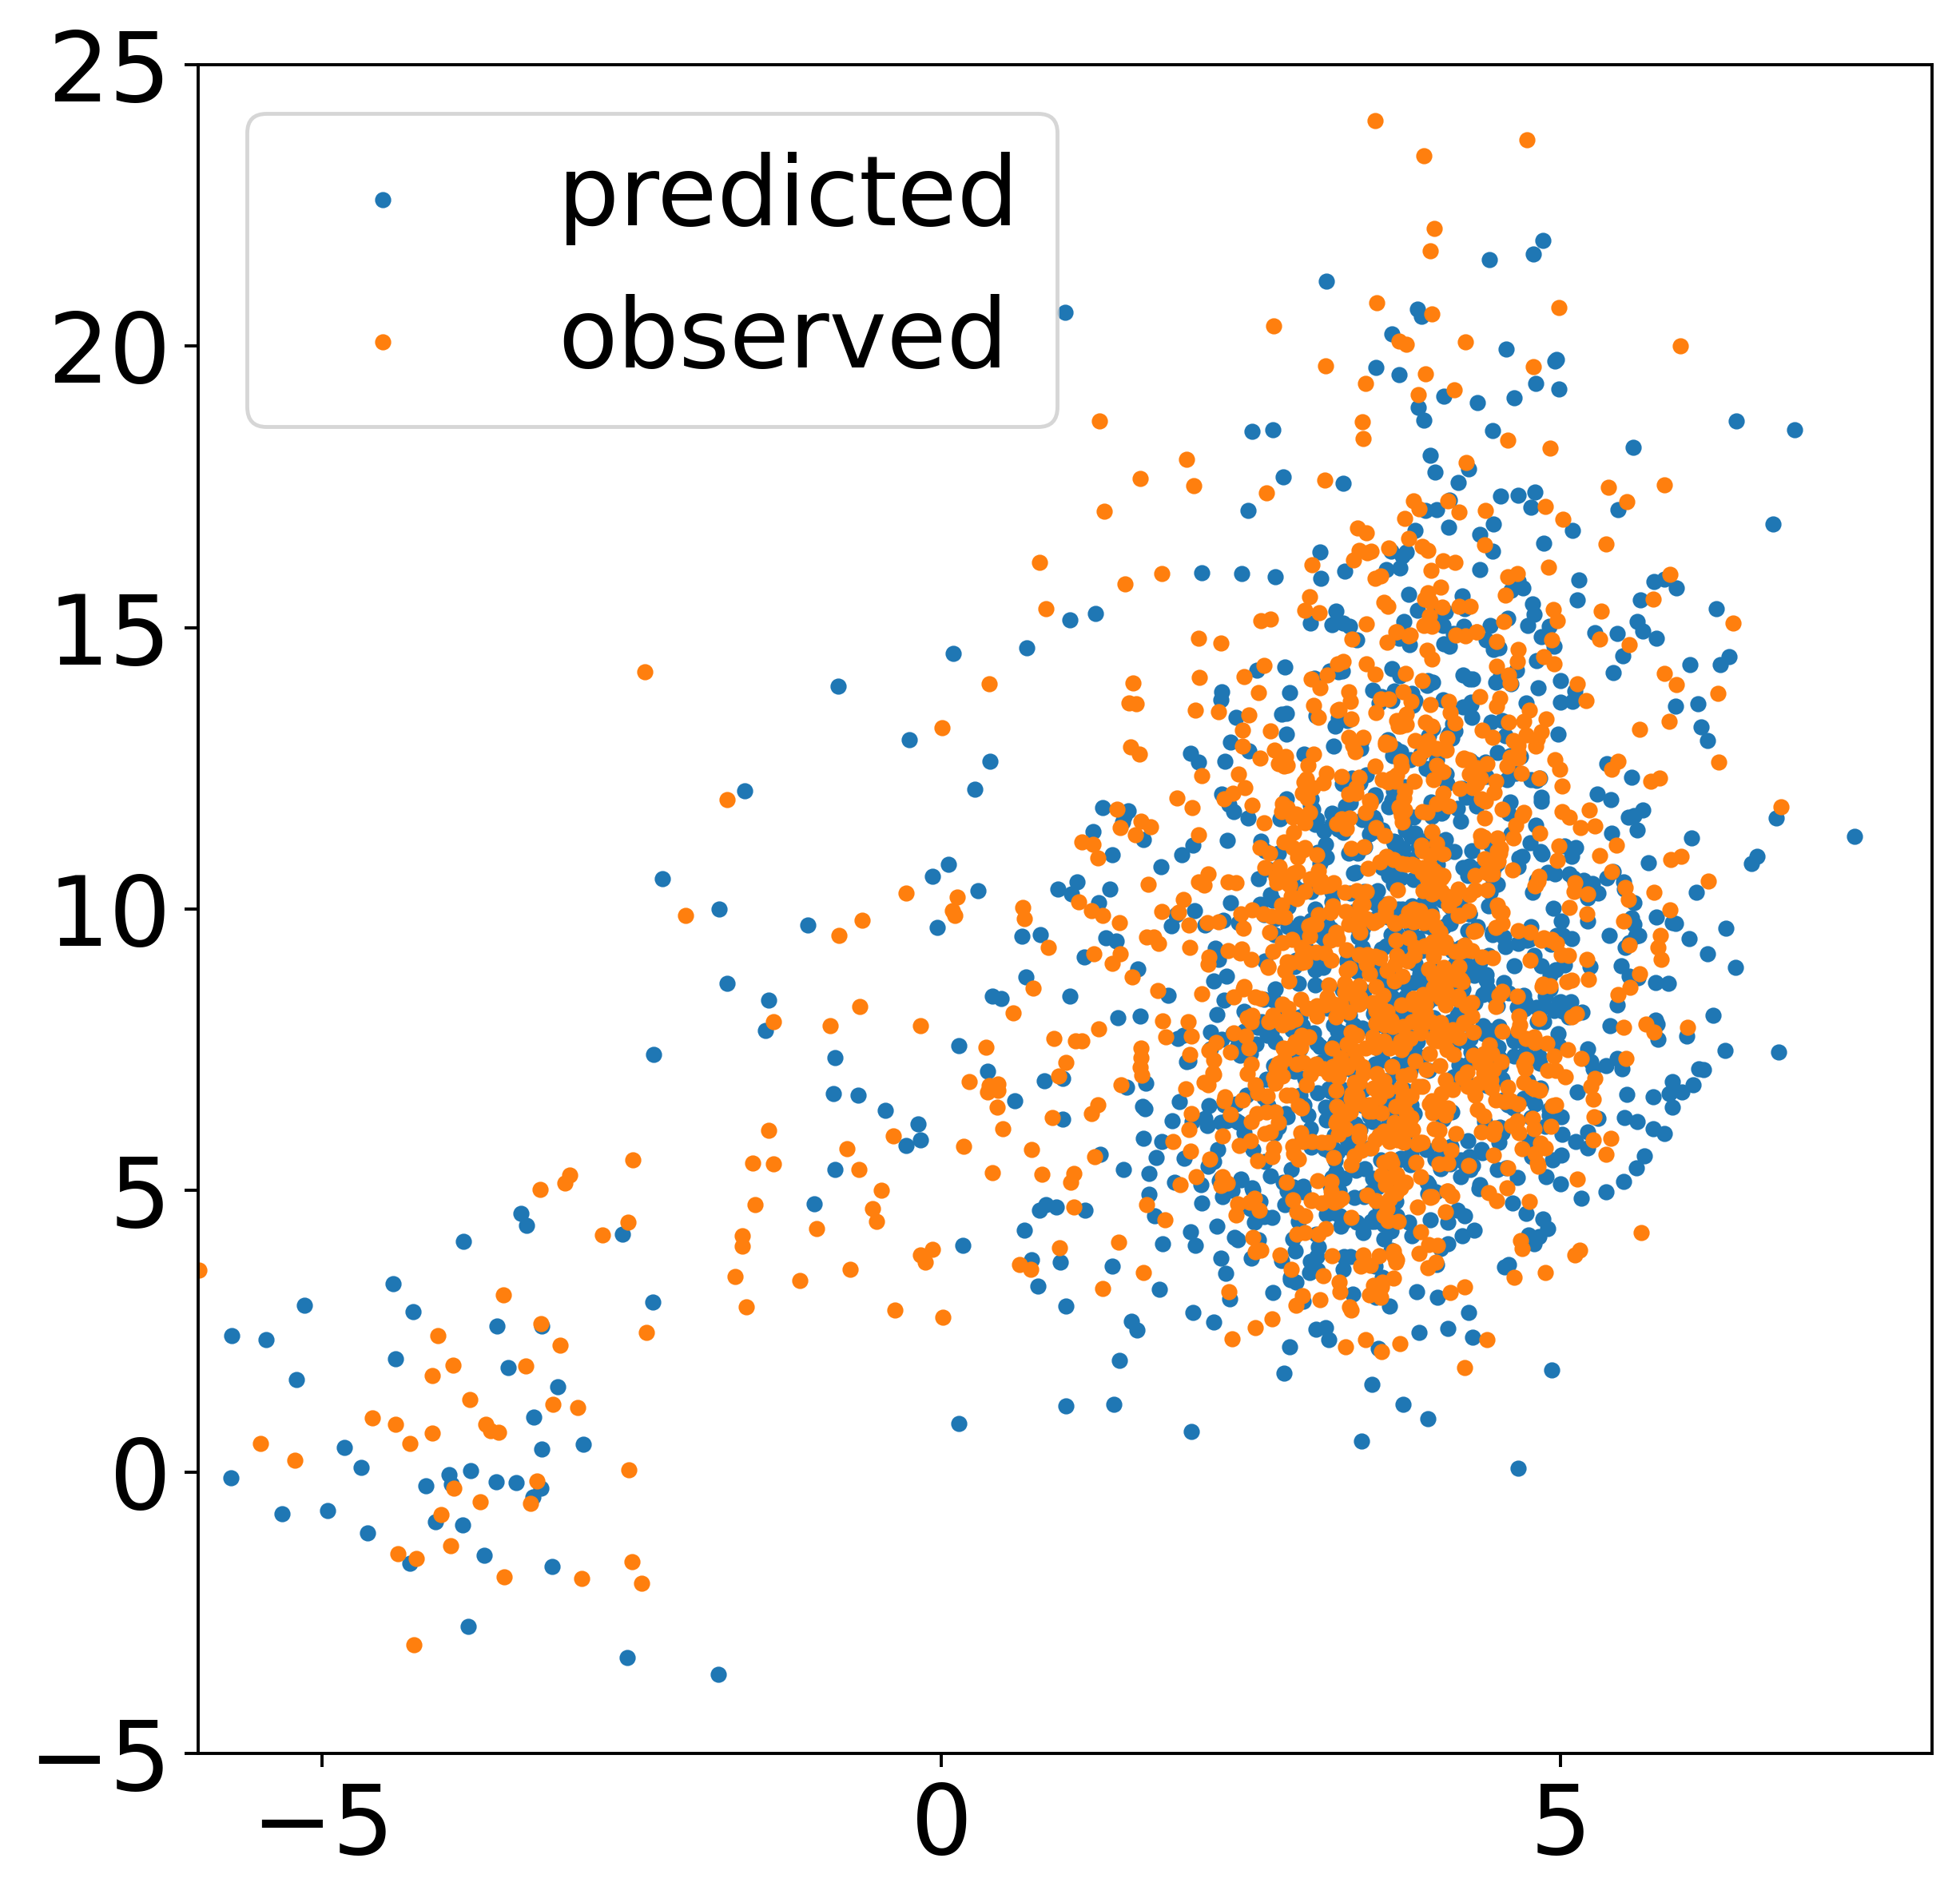

In [13]:
import matplotlib
matplotlib.rcParams.update({'font.size': 25})

setup_seed(100)

daxiao = 10
kuan = (8,8)
import matplotlib
matplotlib.use('Agg')

path = netGou(train0,1200,10)

G2 = path[:,2,:]
G4 = path[:,4,:]
G10 = path[:,10,:]

print(a(G2,train2),a(G4,train4),a(G10,train10))
G2 = G2.detach().cpu().numpy()
G4 = G4.detach().cpu().numpy()
G10 = G10.detach().cpu().numpy()
T2 = train2.detach().cpu().numpy()
T4 = train4.detach().cpu().numpy()
T10 = train10.detach().cpu().numpy()

plt.figure(figsize=kuan,dpi=350)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G2[:,0],G2[:,1],label="predicted",s=10)
plt.scatter(T2[:,0],T2[:,1],label="observed",s=10)
plt.title("2$\delta$")
plt.ylabel("OU")
plt.legend(loc=2,ncol=1)
plt.savefig('./images/OU2.eps',format='eps')

plt.figure(figsize=kuan,dpi=350)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G4[:,0],G4[:,1],label="predicted",s=10)
plt.scatter(T4[:,0],T4[:,1],label="observed",s=10)
plt.title("4$\delta$")
plt.legend(loc=2,ncol=1)
plt.savefig('./images/OU4.eps',format='eps')

plt.figure(figsize=kuan,dpi=350)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G10[:,0],G10[:,1],label="predicted",s=10)
plt.scatter(T10[:,0],T10[:,1],label="observed",s=10)
plt.title("10$\delta$")
plt.legend(loc=2,ncol=1)
plt.savefig('./images/OU10.eps',format='eps')

path = netGnj(train0,1200,10)

G2 = path[:,2,:]
G4 = path[:,4,:]
G10 = path[:,10,:]

print(a(G2,train2),a(G4,train4),a(G10,train10))
G2 = G2.detach().cpu().numpy()
G4 = G4.detach().cpu().numpy()
G10 = G10.detach().cpu().numpy()
T2 = train2.detach().cpu().numpy()
T4 = train4.detach().cpu().numpy()
T10 = train10.detach().cpu().numpy()

plt.figure(figsize=kuan,dpi=350)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G2[:,0],G2[:,1],label="predicted",s=daxiao)
plt.scatter(T2[:,0],T2[:,1],label="observed",s=daxiao)
plt.ylabel("SDEnoJump")
plt.legend(loc=2,ncol=1)
plt.savefig('./images/SDEnoJump2.eps',format='eps')

plt.figure(figsize=kuan,dpi=350)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G4[:,0],G4[:,1],label="predicted",s=daxiao)
plt.scatter(T4[:,0],T4[:,1],label="observed",s=daxiao)
plt.legend(loc=2,ncol=1)
plt.savefig('./images/SDEnoJump4.eps',format='eps')

plt.figure(figsize=kuan,dpi=350)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G10[:,0],G10[:,1],label="predicted",s=daxiao)
plt.scatter(T10[:,0],T10[:,1],label="observed",s=daxiao)
plt.legend(loc=2,ncol=1)
plt.savefig('./images/SDEnoJump10.eps',format='eps')

path = netGwj(train0,1200,10)

G2 = path[:,2,:]
G4 = path[:,4,:]
G10 = path[:,10,:]
print(a(G2,train2),a(G4,train4),a(G10,train10))

G2 = G2.detach().cpu().numpy()
G4 = G4.detach().cpu().numpy()
G10 = G10.detach().cpu().numpy()
T2 = train2.detach().cpu().numpy()
T4 = train4.detach().cpu().numpy()
T10 = train10.detach().cpu().numpy()

plt.figure(figsize=kuan,dpi=350)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G2[:,0],G2[:,1],label="predicted",s=daxiao)
plt.scatter(T2[:,0],T2[:,1],label="observed",s=daxiao)
plt.ylabel("SDEexpJump")
plt.legend(loc=2,ncol=1)
plt.savefig('./images/SDEexpJump2.eps',format='eps')

plt.figure(figsize=kuan,dpi=350)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G4[:,0],G4[:,1],label="predicted",s=daxiao)
plt.scatter(T4[:,0],T4[:,1],label="observed",s=daxiao)
plt.legend(loc=2,ncol=1)
plt.savefig('./images/SDEexpJump4.eps',format='eps')

plt.figure(figsize=kuan,dpi=350)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G10[:,0],G10[:,1],label="predicted",s=daxiao)
plt.scatter(T10[:,0],T10[:,1],label="observed",s=daxiao)
plt.legend(loc=2,ncol=1)
plt.savefig('./images/SDEexpJump10.eps',format='eps')

path = netGwgj(train0,1200,10)

G2 = path[:,2,:]
G4 = path[:,4,:]
G10 = path[:,10,:]
print(a(G2,train2),a(G4,train4),a(G10,train10))

G2 = G2.detach().cpu().numpy()
G4 = G4.detach().cpu().numpy()
G10 = G10.detach().cpu().numpy()
T2 = train2.detach().cpu().numpy()
T4 = train4.detach().cpu().numpy()
T10 = train10.detach().cpu().numpy()

plt.figure(figsize=kuan,dpi=350)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G2[:,0],G2[:,1],label="predicted",s=daxiao)
plt.scatter(T2[:,0],T2[:,1],label="observed",s=daxiao)
plt.ylabel("SDEgauJump")
plt.legend(loc=2,ncol=1)
plt.savefig('./images/SDEgauJump2.eps',format='eps')

plt.figure(figsize=kuan,dpi=350)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G4[:,0],G4[:,1],label="predicted",s=daxiao)
plt.scatter(T4[:,0],T4[:,1],label="observed",s=daxiao)
plt.legend(loc=2,ncol=1)
plt.savefig('./images/SDEgauJump4.eps',format='eps')

plt.figure(figsize=kuan,dpi=350)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G10[:,0],G10[:,1],label="predicted",s=daxiao)
plt.scatter(T10[:,0],T10[:,1],label="observed",s=daxiao)
plt.legend(loc=2,ncol=1)
plt.savefig('./images/SDEgauJump10.eps',format='eps')

tensor(2.0314, device='cuda:0', grad_fn=<SelectBackward>) tensor(6.4115, device='cuda:0', grad_fn=<SelectBackward>) tensor(35.5709, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1862, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.2396, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.2901, device='cuda:0', grad_fn=<SelectBackward>)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


tensor(0.0237, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.0439, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.1025, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0320, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.0104, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.0781, device='cuda:0', grad_fn=<SelectBackward>)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

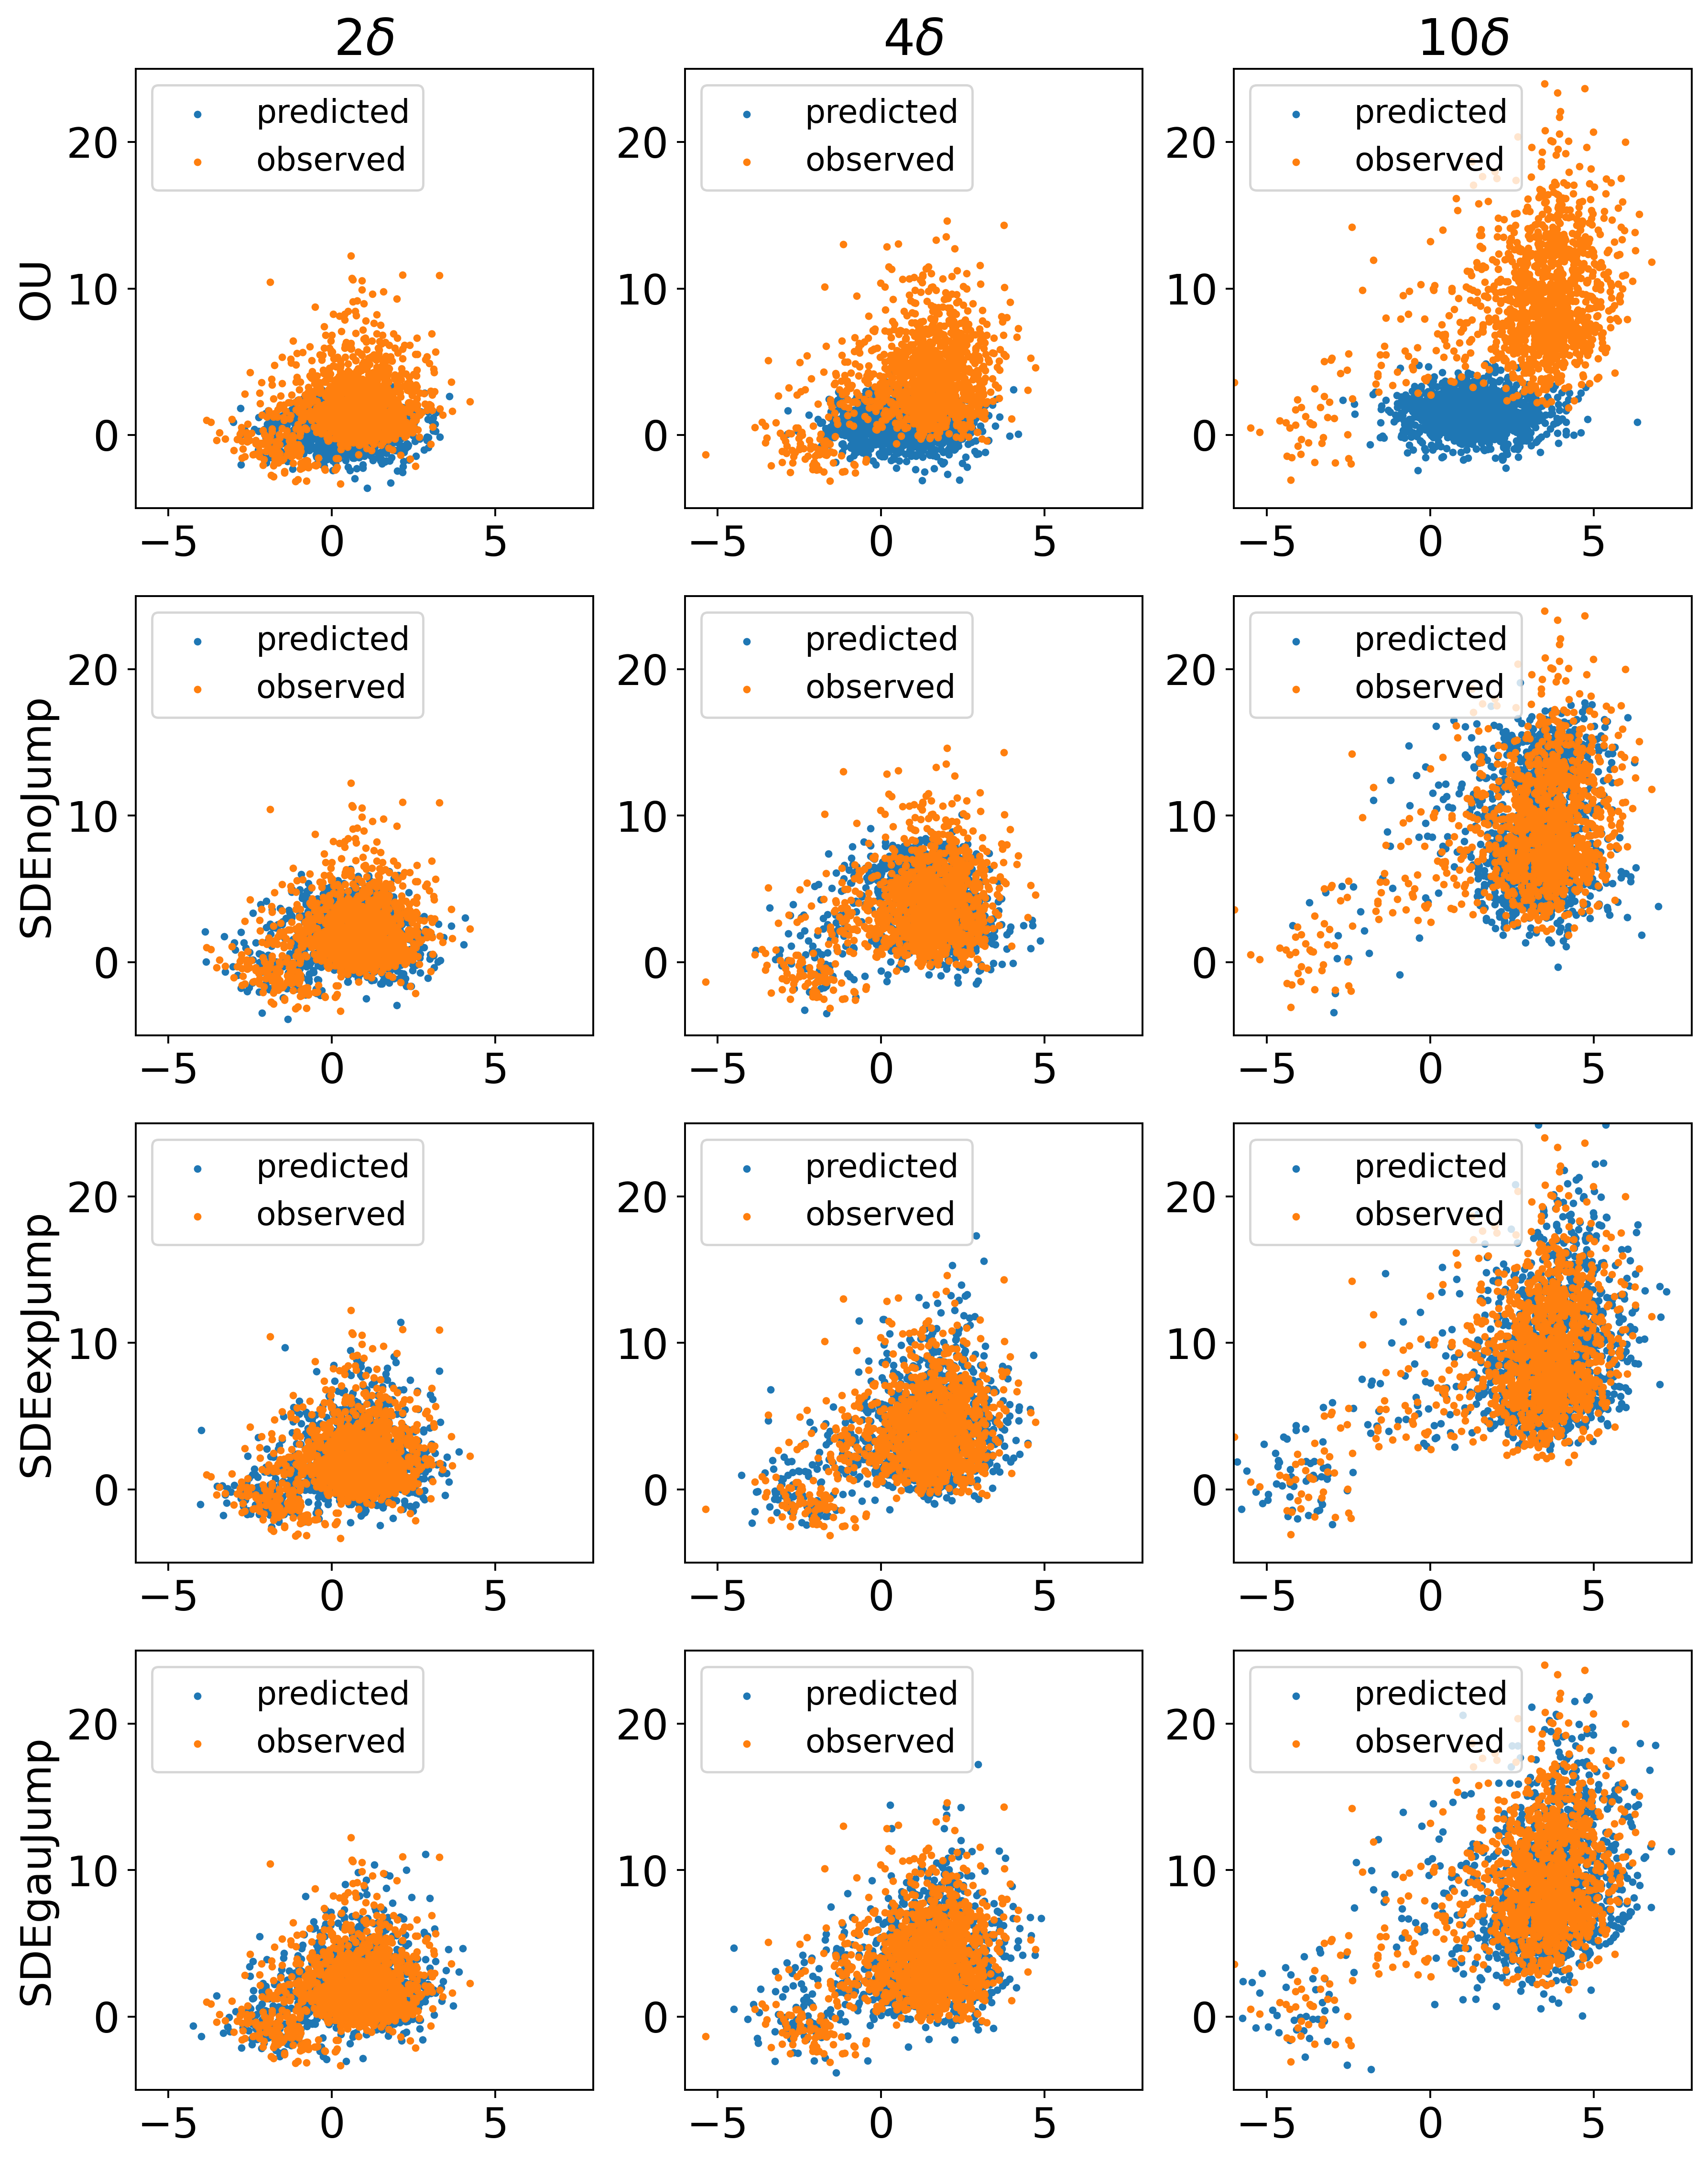

In [34]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

setup_seed(100)

daxiao = 5
kuan = (12,16)
import matplotlib
matplotlib.use('Agg')
plt.figure(figsize=kuan,dpi=350)

path = netGou(train0,1200,10)

G2 = path[:,2,:]
G4 = path[:,4,:]
G10 = path[:,10,:]

print(a(G2,train2),a(G4,train4),a(G10,train10))
G2 = G2.detach().cpu().numpy()
G4 = G4.detach().cpu().numpy()
G10 = G10.detach().cpu().numpy()
T2 = train2.detach().cpu().numpy()
T4 = train4.detach().cpu().numpy()
T10 = train10.detach().cpu().numpy()

plt.subplot(4,3,1)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G2[:,0],G2[:,1],label="predicted",s=daxiao)
plt.scatter(T2[:,0],T2[:,1],label="observed",s=daxiao)
plt.title("2$\delta$")
plt.ylabel("OU")
plt.legend(loc=2,ncol=1,fontsize=14)


plt.subplot(4,3,2)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G4[:,0],G4[:,1],label="predicted",s=daxiao)
plt.scatter(T4[:,0],T4[:,1],label="observed",s=daxiao)
plt.title("4$\delta$")
plt.legend(loc=2,ncol=1,fontsize=14)


plt.subplot(4,3,3)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G10[:,0],G10[:,1],label="predicted",s=daxiao)
plt.scatter(T10[:,0],T10[:,1],label="observed",s=daxiao)
plt.title("10$\delta$")
plt.legend(loc=2,ncol=1,fontsize=14)


path = netGnj(train0,1200,10)

G2 = path[:,2,:]
G4 = path[:,4,:]
G10 = path[:,10,:]

print(a(G2,train2),a(G4,train4),a(G10,train10))
G2 = G2.detach().cpu().numpy()
G4 = G4.detach().cpu().numpy()
G10 = G10.detach().cpu().numpy()
T2 = train2.detach().cpu().numpy()
T4 = train4.detach().cpu().numpy()
T10 = train10.detach().cpu().numpy()

plt.subplot(4,3,4)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G2[:,0],G2[:,1],label="predicted",s=daxiao)
plt.scatter(T2[:,0],T2[:,1],label="observed",s=daxiao)
plt.ylabel("SDEnoJump")
plt.legend(loc=2,ncol=1,fontsize=14)


plt.subplot(4,3,5)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G4[:,0],G4[:,1],label="predicted",s=daxiao)
plt.scatter(T4[:,0],T4[:,1],label="observed",s=daxiao)
plt.legend(loc=2,ncol=1,fontsize=14)


plt.subplot(4,3,6)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G10[:,0],G10[:,1],label="predicted",s=daxiao)
plt.scatter(T10[:,0],T10[:,1],label="observed",s=daxiao)
plt.legend(loc=2,ncol=1,fontsize=14)


path = netGwj(train0,1200,10)

G2 = path[:,2,:]
G4 = path[:,4,:]
G10 = path[:,10,:]
print(a(G2,train2),a(G4,train4),a(G10,train10))

G2 = G2.detach().cpu().numpy()
G4 = G4.detach().cpu().numpy()
G10 = G10.detach().cpu().numpy()
T2 = train2.detach().cpu().numpy()
T4 = train4.detach().cpu().numpy()
T10 = train10.detach().cpu().numpy()

plt.subplot(4,3,7)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G2[:,0],G2[:,1],label="predicted",s=daxiao)
plt.scatter(T2[:,0],T2[:,1],label="observed",s=daxiao)
plt.ylabel("SDEexpJump")
plt.legend(loc=2,ncol=1,fontsize=14)


plt.subplot(4,3,8)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G4[:,0],G4[:,1],label="predicted",s=daxiao)
plt.scatter(T4[:,0],T4[:,1],label="observed",s=daxiao)
plt.legend(loc=2,ncol=1,fontsize=14)


plt.subplot(4,3,9)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G10[:,0],G10[:,1],label="predicted",s=daxiao)
plt.scatter(T10[:,0],T10[:,1],label="observed",s=daxiao)
plt.legend(loc=2,ncol=1,fontsize=14)


path = netGwgj(train0,1200,10)

G2 = path[:,2,:]
G4 = path[:,4,:]
G10 = path[:,10,:]
print(a(G2,train2),a(G4,train4),a(G10,train10))

G2 = G2.detach().cpu().numpy()
G4 = G4.detach().cpu().numpy()
G10 = G10.detach().cpu().numpy()
T2 = train2.detach().cpu().numpy()
T4 = train4.detach().cpu().numpy()
T10 = train10.detach().cpu().numpy()

plt.subplot(4,3,10)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G2[:,0],G2[:,1],label="predicted",s=daxiao)
plt.scatter(T2[:,0],T2[:,1],label="observed",s=daxiao)
plt.ylabel("SDEgauJump")
plt.legend(loc=2,ncol=1,fontsize=14)


plt.subplot(4,3,11)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G4[:,0],G4[:,1],label="predicted",s=daxiao)
plt.scatter(T4[:,0],T4[:,1],label="observed",s=daxiao)
plt.legend(loc=2,ncol=1,fontsize=14)


plt.subplot(4,3,12)
plt.xlim((-6,8))
plt.ylim((-5,25))
plt.scatter(G10[:,0],G10[:,1],label="predicted",s=daxiao)
plt.scatter(T10[:,0],T10[:,1],label="observed",s=daxiao)
plt.legend(loc=2,ncol=1,fontsize=14)


plt.savefig('./images/SyntheticPrediction.eps',format='eps')